
### Entrada
- x1: Local da Coleta em km
- x2: Nivel da Mare em m
- x3: Umidade do Ar (%)
- x4: Índice Pluvimétrico (mm)¹
- x5: Temperatura (°C)

### Saida
- y1: pH
- y2: Condutividade Elétrica (mS.cmˉ¹)
- y3: Oxigênio Dissolvido (mg.Lˉ¹)
- y4: Sólidos Totais Dissolvidos (ppm)


In [1]:
!pip install --upgrade pip
!pip install tensorflow 
!pip install openpyxl

In [2]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

/tmp/ipykernel_122039/3381654816.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


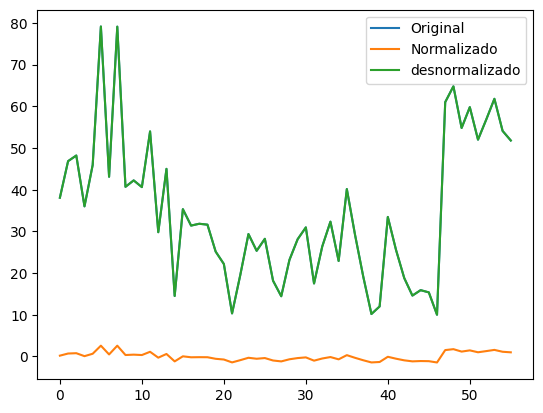

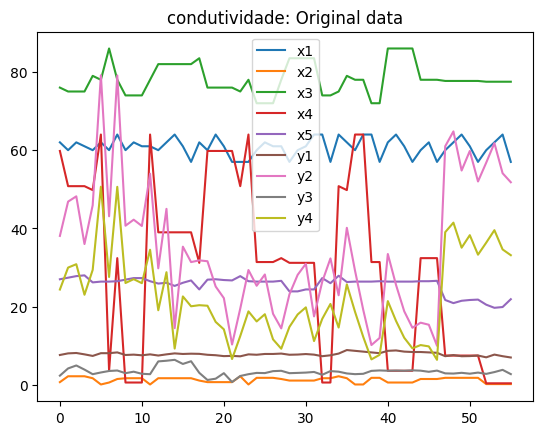

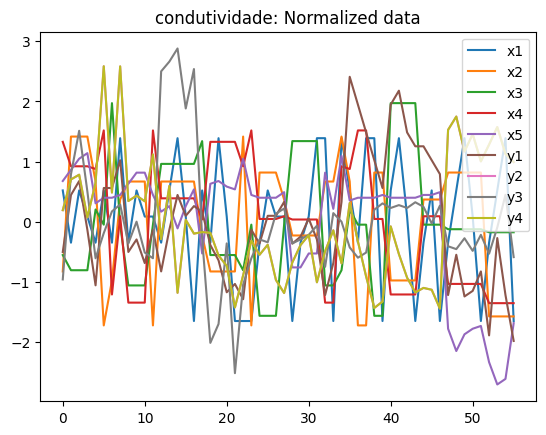

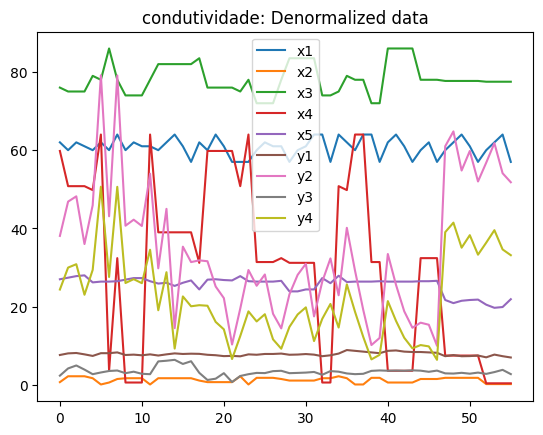

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def getData():
    df_orig = pd.read_excel("../../../data.xlsx")    
    df = pd.DataFrame(scaler.fit_transform(df_orig), columns=df_orig.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df), columns=df.columns)
    return (df_orig, df, df_denorm)

def create_dataframe(df, output):
    x1, x2, x3, x4, x5  = df['x1'], df['x2'], df['x3'], df['x4'], df['x5']

    input = np.vstack([x1, x2, x3, x4, x5 ]).T
    output = np.array(df[output])
    scaler.fit(output.reshape(-1, 1))
    return output, input

def test_out_scaler():
    out = df_orig["y2"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

def show_norm(label):
    df_orig.plot(title=f"{label}: Original data")
    df.plot(title=f"{label}: Normalized data")
    df_denorm.plot(title=f"{label}: Denormalized data")

df_orig, df, df_denorm = getData()
output, input = create_dataframe(df, output="y2")
test_out_scaler()
show_norm(label="condutividade")


In [4]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer
        
        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-04-04 23:40:30.292055: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-04 23:40:30.325300: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-04 23:40:30.325350: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-04 23:40:30.326564: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-04 23:40:30.332398: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-04 23:40:30.333296: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [5]:
import tensorflow as tf
import time
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
    
    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)

      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, input, output):
      input_train, input_vt, output_train, output_vt = train_test_split(input, output, test_size=0.3, shuffle = True)
      input_val, input_test, output_val, output_test = train_test_split(input_vt, output_vt, test_size=0.5, shuffle = True)

      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(input_test, output_test)
      self.vt_dataset, self.vt_input, self.vt_output = self.create_dataset(input_vt, output_vt)
      self.dataset, self.input, self.output = self.create_dataset(input, output)

      self._data = (input, output)
      self._train = (input_train, output_train)
      self._vt = (input_vt, output_vt)
      self._val = (input_val, output_val)
      self._test = (input_test, output_test)
    
    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)

      t2_start = time.perf_counter()
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      t2_stop = time.perf_counter()
      print("Elapsed time: ", t2_stop - t2_start)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)

    def get_metrics(self):
    # Calculando a saida com os dados normalizados
      pred = self.lm_model.predict(self.input).flatten()
      test_pred = self.lm_model.predict(self.test_input).flatten()
      val_pred = self.lm_model.predict(self.val_input).flatten()
      vt_pred = self.lm_model.predict(self.vt_input).flatten()
  
    # Calculando as metricas com a saida desnormalizada
      self.pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
      test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
      val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
      vt_pred_denorm = out_scaler.inverse_transform(vt_pred.reshape(-1, 1))

      self.out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
      test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
      val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
      vt_denorm = out_scaler.inverse_transform(self._vt[1].reshape(-1, 1))      

      r2 = r2_score(self.out_denorm, self.pred_denorm)
      r2_test = r2_score(test_denorm, test_pred_denorm)
      r2_val = r2_score(val_denorm, val_pred_denorm)
      r2_vt = r2_score(vt_denorm,  vt_pred_denorm)

      mse = mean_squared_error(self.out_denorm, self.pred_denorm)
      mse_test = mean_squared_error(test_denorm, test_pred_denorm)
      mse_val = mean_squared_error(val_denorm, val_pred_denorm)
      mse_vt = mean_squared_error(vt_denorm,  vt_pred_denorm)

      metrics = {
                      'r2': r2,
                      'r2_test': r2_test,
                      'r2_val': r2_val,
                      'r2_vt': r2_vt,
                      'mse': mse,
                      'mse_test': mse_test,
                      'mse_val': mse_val,
                      'mse_vt': mse_vt
                      }

      return metrics

In [6]:
from itertools import product
import pickle

class Tester:
  def __init__(self, input, output, run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = input, output
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=5,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path) 

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._vt, trainer._val, trainer._test), f)

  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] >= boundarie): # should be <= to descending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    
    return(save)

# Init
  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinação {count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self.input, self.output)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults(sort_by, header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

In [7]:
tester = Tester(input, output, run_times=25, dataset_run_times=10)

In [8]:
tester.Loop(sort_by='r2',
            boundarie=0.8,
            hidden_sizes = [[5], [10], [15], [20], [25], [30], [35], [40], [45]],
            regularizers=[0.01, 0.1],
            learning_rate=[0.1])

Testando combinação 1: Hidden Size=[5], regularizer=0.01, learning_rate=0.1
+++++++++++ [1_0] | 1 ++++++++++++++++++
Elapsed time:  0.8232627749998755
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Elapsed time:  0.6372510329999841
Stopped at epoch:  11
1/1 [==============================] - 0s 21ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Elapsed time:  0.48777150899991284
Stopped at epoch:  8
1/1 [==============================] - 0s 15ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Elapsed time:  0.349328031000141
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Elapsed time:  0.5687433739999506
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [1_0] | 6 ++++++++++++++++++
Elapsed time:  0.5775497619999896
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [1_0] | 7 +++++++++++++

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_6_10,0.800179,0.048460,0.618661,0.385107,58.834072,223.342547,125.851872,177.464619
model_3_6_0,0.802061,0.814305,0.777808,0.800483,58.280064,43.585781,73.329366,57.582767
model_3_6_9,0.809426,0.125270,0.639900,0.429607,56.111427,205.313790,118.842567,164.621428
model_3_6_8,0.818725,0.209550,0.661397,0.477461,53.373557,185.532038,111.748136,150.810198
model_3_6_1,0.825124,0.799717,0.772863,0.791541,51.489524,47.009715,74.961229,60.163357
model_3_6_7,0.827678,0.300548,0.682646,0.528075,50.737393,164.173288,104.735161,136.202432
model_3_6_6,0.835708,0.396610,0.703041,0.580410,48.373226,141.625712,98.004449,121.098106
model_3_6_2,0.838939,0.752486,0.764656,0.766789,47.421858,58.095676,77.669783,67.307056
model_3_6_5,0.842028,0.494957,0.721951,0.632930,46.512338,118.542087,91.763456,105.940384
model_3_6_3,0.845142,0.679958,0.753196,0.729395,45.595458,75.119265,81.451981,78.099344


DataFrame salvo em ../results/metrics_3_6
+++++++++++ [3_7] | 1 ++++++++++++++++++
Elapsed time:  0.3819429879999916
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [3_7] | 2 ++++++++++++++++++
Elapsed time:  0.3758763920000092
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [3_7] | 3 ++++++++++++++++++
Elapsed time:  0.40869303800036505
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [3_7] | 4 ++++++++++++++++++
Elapsed time:  0.38374664799994207
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [3_7] | 5 ++++++++++++++++++
Elapsed time:  0.3756502329997602
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [3_7] | 6 ++++++++++++++++++
Elapsed time:  0.33498184400013997
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_7] | 7 ++++++++++++++++++
Elapsed time:  0.351388389

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_8_17,0.805557,-1.435152,0.693532,0.283369,57.250774,231.402139,134.208332,185.663883
model_3_8_16,0.811586,-1.349454,0.704314,0.308585,55.475523,223.258689,129.486717,179.130725
model_3_8_15,0.818018,-1.256478,0.715992,0.335929,53.581665,214.423568,124.372443,172.046564
model_3_8_14,0.824828,-1.156102,0.728600,0.365449,51.576667,204.885238,118.851204,164.398634
model_3_8_0,0.825031,-0.174530,0.968463,0.746844,51.516761,111.610593,13.810874,65.587178
model_3_8_13,0.831966,-1.048440,0.742157,0.397138,49.475074,194.654524,112.914593,156.188636
model_3_8_12,0.839349,-0.933972,0.756667,0.430907,47.301158,183.777175,106.560000,147.439694
model_3_8_1,0.843635,-0.128697,0.948485,0.739853,46.039235,107.255263,22.559615,67.398487
model_3_8_11,0.846850,-0.813718,0.772116,0.466547,45.092744,172.349919,99.794669,138.206243
model_3_8_10,0.854276,-0.689454,0.788456,0.503674,42.906181,160.541641,92.638997,128.587465


DataFrame salvo em ../results/metrics_3_8
+++++++++++ [3_9] | 1 ++++++++++++++++++
Elapsed time:  0.5260843769997336
Stopped at epoch:  8
1/1 [==============================] - 0s 21ms/step
+++++++++++ [3_9] | 2 ++++++++++++++++++
Elapsed time:  0.3607630770002288
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [3_9] | 3 ++++++++++++++++++
Elapsed time:  0.2901906090000921
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [3_9] | 4 ++++++++++++++++++
Elapsed time:  0.3334513390000211
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_9] | 5 ++++++++++++++++++
Elapsed time:  0.34935136200010675
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [3_9] | 6 ++++++++++++++++++
Elapsed time:  0.3337052169999879
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [3_9] | 7 ++++++++++++++++++
Elapsed time:  0.37276241400

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_3_9_8,0.809416,0.436918,0.337520,0.470012,56.114538,226.985346,102.206407,168.265843
model_3_9_7,0.818596,0.470946,0.413194,0.510190,53.411705,213.268182,90.531448,155.509717
model_3_9_6,0.827033,0.506722,0.486302,0.550956,50.927301,198.846416,79.252536,142.566912
model_3_9_5,0.834440,0.544400,0.555512,0.592109,48.746681,183.657801,68.574936,129.501212
model_3_9_0,0.839931,0.768102,0.767660,0.790991,47.129895,93.481091,35.845065,66.358237
model_3_9_4,0.840473,0.584230,0.619220,0.633451,46.970331,167.601748,58.746081,116.375554
model_3_9_3,0.844720,0.626548,0.675441,0.674753,45.719766,150.543052,50.072438,103.262754
model_3_9_1,0.845458,0.719343,0.753775,0.755041,45.502600,113.136219,37.987202,77.772030
model_3_9_2,0.846645,0.671648,0.721521,0.715605,45.153058,132.362675,42.963282,90.292367


DataFrame salvo em ../results/metrics_3_9
Testando combinação 4: Hidden Size=[10], regularizer=0.1, learning_rate=0.1
+++++++++++ [4_0] | 1 ++++++++++++++++++
Elapsed time:  0.6545912159999716
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [4_0] | 2 ++++++++++++++++++
Elapsed time:  0.3867791159996159
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [4_0] | 3 ++++++++++++++++++
Elapsed time:  0.3851030499999979
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [4_0] | 4 ++++++++++++++++++
Elapsed time:  0.3476303560000815
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [4_0] | 5 ++++++++++++++++++
Elapsed time:  0.3732501350000348
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [4_0] | 6 ++++++++++++++++++
Elapsed time:  0.3538510660000611
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms

2024-04-04 23:48:50.028159: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_4] | 19 ++++++++++++++++++
Elapsed time:  0.4058116229998632
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [4_4] | 20 ++++++++++++++++++
Elapsed time:  0.3318335809999553
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [4_4] | 21 ++++++++++++++++++
Elapsed time:  0.3690572489999795
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [4_4] | 22 ++++++++++++++++++
Elapsed time:  0.31732133400009843
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_4] | 23 ++++++++++++++++++
Elapsed time:  0.3819171370000731
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [4_4] | 24 ++++++++++++++++++
Elapsed time:  0.3549797910000052
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_4] | 25 ++++++++++++++++++
Elapsed tim

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_8_7,0.800282,-0.136101,0.519122,0.301419,58.803810,216.433655,113.270069,167.886063
model_4_8_6,0.818938,0.006170,0.606230,0.401302,53.310981,189.330196,92.751928,143.881611
model_4_8_5,0.839627,0.170977,0.701891,0.514588,47.219242,157.933544,70.219123,116.656185
model_4_8_4,0.859860,0.350077,0.793878,0.632178,41.262047,123.814093,48.551661,88.396495
model_4_8_3,0.875673,0.523996,0.868623,0.739642,36.606113,90.681455,30.945610,62.570453
model_4_8_0,0.876386,0.891831,0.979577,0.945185,36.396149,20.606771,4.810669,13.173307
model_4_8_2,0.884217,0.675408,0.921931,0.827771,34.090543,61.836651,18.389062,41.390731
model_4_8_1,0.884527,0.797932,0.957249,0.895481,33.999164,38.495034,10.069864,25.118483


DataFrame salvo em ../results/metrics_4_8
+++++++++++ [4_9] | 1 ++++++++++++++++++
Elapsed time:  0.6626197340001454
Stopped at epoch:  10
1/1 [==============================] - 0s 16ms/step
+++++++++++ [4_9] | 2 ++++++++++++++++++
Elapsed time:  0.3911588579999261
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_9] | 3 ++++++++++++++++++
Elapsed time:  0.361006166000152
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [4_9] | 4 ++++++++++++++++++
Elapsed time:  0.375540588000149
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_9] | 5 ++++++++++++++++++
Elapsed time:  0.31071876400028486
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_9] | 6 ++++++++++++++++++
Elapsed time:  0.34010539700011577
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [4_9] | 7 ++++++++++++++++++
Elapsed time:  0.30698719700

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_4_9_0,0.851800,0.599915,0.922896,0.812963,43.635068,70.733874,26.647993,49.987571
model_4_9_24,0.860857,0.305117,0.573807,0.497284,40.968361,122.853262,147.296664,134.356023
model_4_9_23,0.861569,0.306711,0.577992,0.500390,40.758967,122.571344,145.850113,133.526001
model_4_9_22,0.862348,0.308543,0.582654,0.503868,40.529347,122.247460,144.239100,132.596487
model_4_9_1,0.863124,0.564983,0.900406,0.787044,40.301058,76.909724,34.420551,56.914818
model_4_9_21,0.863202,0.310651,0.587844,0.507765,40.278011,121.874724,142.445142,131.554907
model_4_9_20,0.864134,0.313083,0.593624,0.512134,40.003614,121.444776,140.447761,130.387328
model_4_9_19,0.865148,0.315890,0.600056,0.517031,39.705047,120.948467,138.224558,129.078401
model_4_9_18,0.866248,0.319139,0.607214,0.522525,39.381257,120.374106,135.750889,127.610200
model_4_9_17,0.867435,0.322900,0.615174,0.528686,39.031830,119.709109,132.999675,125.963541


DataFrame salvo em ../results/metrics_4_9
Testando combinação 5: Hidden Size=[15], regularizer=0.01, learning_rate=0.1
+++++++++++ [5_0] | 1 ++++++++++++++++++
Elapsed time:  0.7936650090000512
Stopped at epoch:  7
1/1 [==============================] - 0s 26ms/step
+++++++++++ [5_0] | 2 ++++++++++++++++++
Elapsed time:  0.5403789659999347
Stopped at epoch:  8
1/1 [==============================] - 0s 20ms/step
+++++++++++ [5_0] | 3 ++++++++++++++++++
Elapsed time:  0.340671325999665
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [5_0] | 4 ++++++++++++++++++
Elapsed time:  0.26729331599972284
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_0] | 5 ++++++++++++++++++
Elapsed time:  0.33289029899970046
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [5_0] | 6 ++++++++++++++++++
Elapsed time:  0.26792956300005244
Stopped at epoch:  6
1/1 [==============================] - 0s 2

2024-04-04 23:50:56.829672: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_1] | 10 ++++++++++++++++++
Elapsed time:  0.31076869499975146
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [5_1] | 11 ++++++++++++++++++
Elapsed time:  0.3272082819999014
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [5_1] | 12 ++++++++++++++++++
Elapsed time:  0.33366028599994024
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_1] | 13 ++++++++++++++++++
Elapsed time:  0.4036649979998401
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_1] | 14 ++++++++++++++++++
Elapsed time:  0.35509326500005045
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [5_1] | 15 ++++++++++++++++++
Elapsed time:  0.32735743300008835
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [5_1] | 16 ++++++++++++++++++
Elapsed 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_2_24,0.827656,0.594339,0.643331,0.614377,50.743912,197.674341,132.659131,167.078995
model_5_2_23,0.827925,0.595072,0.643842,0.615020,50.664852,197.317144,132.469016,166.800389
model_5_2_22,0.828219,0.595886,0.644401,0.615730,50.578267,196.920902,132.261119,166.492746
model_5_2_21,0.828540,0.596788,0.645012,0.616514,50.483579,196.481303,132.033928,166.153138
model_5_2_20,0.828891,0.597788,0.645677,0.617379,50.380247,195.993640,131.786687,165.778552
model_5_2_19,0.829273,0.598898,0.646399,0.618331,50.267798,195.452909,131.518102,165.365920
model_5_2_18,0.829688,0.600128,0.647181,0.619379,50.145736,194.853431,131.227201,164.911710
model_5_2_17,0.830136,0.601491,0.648024,0.620532,50.013717,194.189275,130.913473,164.412454
model_5_2_16,0.830619,0.603001,0.648930,0.621796,49.871482,193.453597,130.576623,163.864437
model_5_2_15,0.831137,0.604673,0.649897,0.623183,49.718932,192.638895,130.216789,163.263776


DataFrame salvo em ../results/metrics_5_2
+++++++++++ [5_3] | 1 ++++++++++++++++++
Elapsed time:  0.3062174709998544
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_3] | 2 ++++++++++++++++++
Elapsed time:  0.36575499500031583
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [5_3] | 3 ++++++++++++++++++
Elapsed time:  0.3844060060000629
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_3] | 4 ++++++++++++++++++
Elapsed time:  0.45254291599985663
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [5_3] | 5 ++++++++++++++++++
Elapsed time:  0.29417529700003797
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_3] | 6 ++++++++++++++++++
Elapsed time:  0.3039165969998976
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [5_3] | 7 ++++++++++++++++++
Elapsed time:  0.335925447

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_3_24,0.819084,0.789306,0.030478,0.447428,53.267925,53.025120,312.130641,174.957107
model_5_3_23,0.820350,0.791306,0.037620,0.451687,52.895048,52.521948,309.831415,173.608777
model_5_3_22,0.821748,0.793491,0.045625,0.456436,52.483439,51.971963,307.254441,172.104899
model_5_3_21,0.823290,0.795876,0.054599,0.461734,52.029623,51.371815,304.365121,170.427514
model_5_3_20,0.824986,0.798472,0.064659,0.467640,51.530212,50.718434,301.126412,168.557490
model_5_3_19,0.826849,0.801291,0.075935,0.474222,50.981726,50.008983,297.496184,166.473536
model_5_3_18,0.828889,0.804343,0.088571,0.481553,50.380823,49.240803,293.428167,164.152515
model_5_3_17,0.831119,0.807637,0.102724,0.489711,49.724418,48.411804,288.871729,161.569414
model_5_3_16,0.833545,0.811179,0.118566,0.498782,49.009940,47.520449,283.771559,158.697435
model_5_3_15,0.836176,0.814971,0.136286,0.508856,48.235421,46.566237,278.066574,155.507591


DataFrame salvo em ../results/metrics_5_3
+++++++++++ [5_4] | 1 ++++++++++++++++++
Elapsed time:  0.36085539799978505
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [5_4] | 2 ++++++++++++++++++
Elapsed time:  0.4394710749998012
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_4] | 3 ++++++++++++++++++
Elapsed time:  0.30833058200005325
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_4] | 4 ++++++++++++++++++
Elapsed time:  0.45665391300008196
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_4] | 5 ++++++++++++++++++
Elapsed time:  0.40449102899992795
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [5_4] | 6 ++++++++++++++++++
Elapsed time:  0.3393205349998425
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_4] | 7 ++++++++++++++++++
Elapsed time:  0.33339387

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_4_0,0.847562,0.832586,0.990183,0.865455,44.882839,85.519843,1.479024,45.971221
model_5_4_1,0.870251,0.849297,0.965179,0.873493,38.202485,76.983546,5.246137,43.224764
model_5_4_2,0.887680,0.865041,0.923289,0.877262,33.070907,68.941103,11.557424,41.937023
model_5_4_24,0.892473,0.906089,-0.103122,0.696769,31.659688,47.972344,166.197324,103.607606
model_5_4_23,0.893799,0.906693,-0.085034,0.701000,31.269337,47.664090,163.472174,102.161989
model_5_4_22,0.895236,0.907334,-0.065031,0.705658,30.846005,47.336718,160.458566,100.570523
model_5_4_21,0.896790,0.908009,-0.042927,0.710779,30.388510,46.991613,157.128306,98.820641
model_5_4_20,0.898462,0.908715,-0.018519,0.716402,29.896152,46.631154,153.451089,96.899369
model_5_4_19,0.900253,0.909444,0.008402,0.722566,29.368896,46.258848,149.395005,94.793503
model_5_4_3,0.900392,0.878382,0.868253,0.876402,29.327883,62.126003,19.849117,42.230998


DataFrame salvo em ../results/metrics_5_4
+++++++++++ [5_5] | 1 ++++++++++++++++++
Elapsed time:  0.43815788499978225
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [5_5] | 2 ++++++++++++++++++
Elapsed time:  0.36431328600019697
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [5_5] | 3 ++++++++++++++++++
Elapsed time:  0.5688362230002895
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [5_5] | 4 ++++++++++++++++++
Elapsed time:  0.3631725780001034
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_5] | 5 ++++++++++++++++++
Elapsed time:  0.3381538899998304
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_5] | 6 ++++++++++++++++++
Elapsed time:  0.38641963800000667
Stopped at epoch:  6
1/1 [==============================] - 0s 36ms/step
+++++++++++ [5_5] | 7 ++++++++++++++++++
Elapsed time:  0.373483436

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_5_0,0.912618,0.983733,0.990079,0.987566,25.728256,3.900057,4.004052,3.948999
model_5_5_1,0.928066,0.979896,0.991223,0.986717,21.179882,4.819850,3.542231,4.218615
model_5_5_2,0.939698,0.973111,0.990053,0.983306,17.754836,6.446584,4.014473,5.302062
model_5_5_24,0.940704,0.726520,0.882708,0.820561,17.458715,65.567279,47.338141,56.988877
model_5_5_23,0.941704,0.731612,0.885054,0.823999,17.164436,64.346394,46.391486,55.897024
model_5_5_22,0.942788,0.737219,0.887640,0.827786,16.845175,63.002199,45.347672,54.694180
model_5_5_21,0.943960,0.743385,0.890489,0.831954,16.499994,61.523886,44.197953,53.370517
model_5_5_20,0.945223,0.750157,0.893622,0.836534,16.128350,59.900201,42.933568,51.915931
model_5_5_19,0.946575,0.757583,0.897060,0.841558,15.730279,58.119797,41.545911,50.320317
model_5_5_18,0.948014,0.765713,0.900825,0.847059,15.306467,56.170677,40.026221,48.573300


DataFrame salvo em ../results/metrics_5_5
+++++++++++ [5_6] | 1 ++++++++++++++++++
Elapsed time:  0.6017580869997801
Stopped at epoch:  10
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_6] | 2 ++++++++++++++++++
Elapsed time:  0.27971611300017685
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_6] | 3 ++++++++++++++++++
Elapsed time:  0.3630871540003682
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_6] | 4 ++++++++++++++++++
Elapsed time:  0.34902544500027943
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_6] | 5 ++++++++++++++++++
Elapsed time:  0.36415582600011476
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [5_6] | 6 ++++++++++++++++++
Elapsed time:  0.4085615629996937
Stopped at epoch:  6
1/1 [==============================] - 0s 61ms/step
+++++++++++ [5_6] | 7 ++++++++++++++++++
Elapsed time:  0.56603735

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_6_24,0.965358,0.789908,0.896284,0.859827,10.199903,34.768507,32.088250,33.507206
model_5_6_23,0.965634,0.792504,0.896712,0.861039,10.118561,34.338933,31.955869,33.217519
model_5_6_22,0.965933,0.795340,0.897181,0.862365,10.030530,33.869604,31.810678,32.900688
model_5_6_21,0.966255,0.798430,0.897695,0.863810,9.935715,33.358246,31.651757,32.555198
model_5_6_20,0.966600,0.801788,0.898256,0.865383,9.834020,32.802578,31.477998,32.179249
model_5_6_19,0.966969,0.805426,0.898868,0.867089,9.725571,32.200403,31.288836,31.771428
model_5_6_18,0.967359,0.809356,0.899532,0.868933,9.610671,31.550127,31.083382,31.330469
model_5_6_0,0.967693,0.952089,0.912414,0.929094,9.512425,7.928946,27.097867,16.949621
model_5_6_17,0.967769,0.813586,0.900250,0.870921,9.489841,30.850076,30.861275,30.855330
model_5_6_16,0.968197,0.818124,0.901022,0.873055,9.363913,30.099091,30.622298,30.345321


DataFrame salvo em ../results/metrics_5_6
+++++++++++ [5_7] | 1 ++++++++++++++++++
Elapsed time:  0.39006947200005015
Stopped at epoch:  7
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_7] | 2 ++++++++++++++++++
Elapsed time:  0.3633533809997971
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_7] | 3 ++++++++++++++++++
Elapsed time:  0.38545474100010324
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [5_7] | 4 ++++++++++++++++++
Elapsed time:  0.4806050800002595
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [5_7] | 5 ++++++++++++++++++
Elapsed time:  0.3932806409998193
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_7] | 6 ++++++++++++++++++
Elapsed time:  0.3590675740001643
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_7] | 7 ++++++++++++++++++
Elapsed time:  0.3274496630

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_7_24,0.970938,0.957262,0.823107,0.910513,8.556907,14.705427,43.127956,28.080724
model_5_7_23,0.971244,0.957818,0.825033,0.911540,8.466664,14.514021,42.658350,27.758407
model_5_7_22,0.971579,0.958433,0.827154,0.912672,8.368197,14.302573,42.141225,27.403115
model_5_7_21,0.971943,0.959111,0.829487,0.913919,8.261023,14.069229,41.572365,27.011881
model_5_7_20,0.972338,0.959859,0.832051,0.915290,8.144698,13.811865,40.947390,26.581530
model_5_7_19,0.972765,0.960683,0.834863,0.916797,8.018836,13.528260,40.261689,26.108696
model_5_7_18,0.973226,0.961590,0.837944,0.918450,7.883214,13.216152,39.510661,25.590042
model_5_7_17,0.973720,0.962588,0.841311,0.920260,7.737735,12.873028,38.689610,25.022004
model_5_7_0,0.974178,0.996503,0.934997,0.974203,7.603024,1.203397,15.848246,8.095096
model_5_7_16,0.974247,0.963682,0.844985,0.922239,7.582509,12.496264,37.793844,24.401009


DataFrame salvo em ../results/metrics_5_7
+++++++++++ [5_8] | 1 ++++++++++++++++++
Elapsed time:  0.5976419909998185
Stopped at epoch:  11
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_8] | 2 ++++++++++++++++++
Elapsed time:  0.37849895199997263
Stopped at epoch:  6
1/1 [==============================] - 0s 33ms/step
+++++++++++ [5_8] | 3 ++++++++++++++++++
Elapsed time:  0.37831123699970703
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_8] | 4 ++++++++++++++++++
Elapsed time:  0.3387835929997891
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [5_8] | 5 ++++++++++++++++++
Elapsed time:  0.46766845100000864
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [5_8] | 6 ++++++++++++++++++
Elapsed time:  0.32296246599980805
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [5_8] | 7 ++++++++++++++++++
Elapsed time:  0.3527085

2024-04-04 23:53:06.259785: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 53ms/step
+++++++++++ [5_8] | 14 ++++++++++++++++++
Elapsed time:  0.38019636299986814
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [5_8] | 15 ++++++++++++++++++
Elapsed time:  0.3016978730001938
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [5_8] | 16 ++++++++++++++++++
Elapsed time:  0.3762757879999299
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [5_8] | 17 ++++++++++++++++++
Elapsed time:  0.3370505670000057
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [5_8] | 18 ++++++++++++++++++
Elapsed time:  0.2966824660002203
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [5_8] | 19 ++++++++++++++++++
Elapsed time:  0.32210357199983264
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [5_8] | 20 ++++++++++++++++++
Elapsed ti

2024-04-04 23:53:13.874460: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.3996389280000585
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [5_8] | 25 ++++++++++++++++++
Elapsed time:  0.38923120999970706
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step


,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_8_24,0.982836,0.933879,0.770466,0.895154,5.053542,14.295831,19.205819,16.606415
model_5_8_23,0.982966,0.934406,0.772356,0.896005,5.015502,14.181763,19.047668,16.471598
model_5_8_22,0.983107,0.934990,0.774435,0.896944,4.973921,14.055511,18.873720,16.322891
model_5_8_21,0.983261,0.935636,0.776719,0.897979,4.928566,13.915865,18.682534,16.159003
model_5_8_20,0.983428,0.936350,0.779226,0.899118,4.879221,13.761490,18.472812,15.978578
model_5_8_19,0.983610,0.937139,0.781971,0.900370,4.825707,13.591000,18.243117,15.780232
model_5_8_18,0.983807,0.938009,0.784973,0.901745,4.767852,13.402822,17.991971,15.562421
model_5_8_17,0.984018,0.938969,0.788245,0.903253,4.705578,13.195266,17.718138,15.323672
model_5_8_16,0.984245,0.940027,0.791807,0.904903,4.638841,12.966562,17.420114,15.062348
model_5_8_15,0.984486,0.941191,0.795673,0.906705,4.567721,12.714838,17.096674,14.776882


DataFrame salvo em ../results/metrics_5_8
+++++++++++ [5_9] | 1 ++++++++++++++++++
Elapsed time:  0.38631114999998317
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [5_9] | 2 ++++++++++++++++++
Elapsed time:  0.3499526280002101
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [5_9] | 3 ++++++++++++++++++
Elapsed time:  0.28892912399987836
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [5_9] | 4 ++++++++++++++++++
Elapsed time:  0.3199395509996066
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [5_9] | 5 ++++++++++++++++++
Elapsed time:  0.2940320679999786
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [5_9] | 6 ++++++++++++++++++
Elapsed time:  0.3204829240003164
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [5_9] | 7 ++++++++++++++++++
Elapsed time:  0.3839297389

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_5_9_24,0.976373,0.870727,0.899734,0.886664,6.956606,22.860892,22.848130,22.854891
model_5_9_23,0.976697,0.872699,0.901074,0.888292,6.861298,22.512209,22.542838,22.526622
model_5_9_22,0.977051,0.874863,0.902550,0.890081,6.757111,22.129549,22.206465,22.165753
model_5_9_21,0.977437,0.877233,0.904175,0.892046,6.643461,21.710377,21.836115,21.769566
model_5_9_20,0.977857,0.879826,0.905962,0.894200,6.519761,21.251743,21.428995,21.335155
model_5_9_19,0.978313,0.882658,0.907924,0.896559,6.385481,20.750915,20.981831,20.859576
model_5_9_18,0.978806,0.885744,0.910075,0.899135,6.240213,20.205223,20.491640,20.340003
model_5_9_17,0.979338,0.889098,0.912430,0.901944,6.083623,19.612094,19.955051,19.773494
model_5_9_16,0.979909,0.892734,0.915001,0.905000,5.915576,18.969095,19.369134,19.157345
model_5_9_15,0.980518,0.896663,0.917802,0.908313,5.736185,18.274357,18.730797,18.489148


DataFrame salvo em ../results/metrics_5_9
Testando combinação 6: Hidden Size=[15], regularizer=0.1, learning_rate=0.1
+++++++++++ [6_0] | 1 ++++++++++++++++++
Elapsed time:  0.6233999199998834
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_0] | 2 ++++++++++++++++++
Elapsed time:  0.5642534529997647
Stopped at epoch:  7
1/1 [==============================] - 0s 18ms/step
+++++++++++ [6_0] | 3 ++++++++++++++++++
Elapsed time:  0.35651025700008176
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_0] | 4 ++++++++++++++++++
Elapsed time:  0.38243780499988134
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [6_0] | 5 ++++++++++++++++++
Elapsed time:  0.3109900040003595
Stopped at epoch:  6
1/1 [==============================] - 0s 37ms/step
+++++++++++ [6_0] | 6 ++++++++++++++++++
Elapsed time:  0.375946089000081
Stopped at epoch:  6
1/1 [==============================] - 0s 26m

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_5_0,0.809736,0.463267,0.585339,0.546490,56.020120,255.626794,21.427763,145.415477
model_6_5_1,0.818302,0.471925,0.533788,0.549388,53.498192,251.503459,24.091649,144.486119
model_6_5_2,0.825340,0.480168,0.482555,0.551985,51.426023,247.577555,26.739137,143.653574
model_6_5_3,0.831005,0.487525,0.432102,0.553943,49.757879,244.073808,29.346311,143.025543
model_6_5_4,0.835452,0.493703,0.382934,0.555072,48.448606,241.131553,31.887122,142.663576
model_6_5_5,0.838840,0.498594,0.335522,0.555323,47.450947,238.802090,34.337155,142.583260
model_6_5_6,0.841335,0.502242,0.290254,0.554758,46.716351,237.064470,36.676387,142.764211
model_6_5_7,0.843098,0.504790,0.247405,0.553512,46.197419,235.851147,38.890619,143.163860
model_6_5_17,0.843867,0.504472,-0.044211,0.531146,45.971033,236.002563,53.959979,150.335463
model_6_5_16,0.844256,0.505127,-0.024907,0.533125,45.856523,235.690350,52.962434,149.700732


DataFrame salvo em ../results/metrics_6_5
+++++++++++ [6_6] | 1 ++++++++++++++++++
Elapsed time:  0.3142063150003196
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [6_6] | 2 ++++++++++++++++++
Elapsed time:  0.3808900369999719
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [6_6] | 3 ++++++++++++++++++
Elapsed time:  0.5277729760000511
Stopped at epoch:  6
1/1 [==============================] - 0s 34ms/step
+++++++++++ [6_6] | 4 ++++++++++++++++++
Elapsed time:  0.39801519100001315
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [6_6] | 5 ++++++++++++++++++
Elapsed time:  0.39452538000023196
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [6_6] | 6 ++++++++++++++++++
Elapsed time:  0.3490324699996563
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_6] | 7 ++++++++++++++++++
Elapsed time:  0.3424667599

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_6_0,0.861089,0.696167,0.884733,0.799755,40.900302,68.542453,35.066491,52.789051
model_6_6_1,0.873820,0.691991,0.864683,0.786975,37.151597,69.484645,41.165935,56.158191
model_6_6_2,0.883114,0.685849,0.844157,0.773045,34.415253,70.870191,47.410570,59.830378
model_6_6_24,0.889361,0.567892,0.614504,0.594892,32.575897,97.480402,117.275302,106.795651
model_6_6_3,0.889777,0.678513,0.823865,0.758702,32.453339,72.525251,53.583687,63.611579
model_6_6_23,0.889977,0.569932,0.617815,0.597614,32.394627,97.020348,116.268051,106.078093
model_6_6_22,0.890642,0.572183,0.621480,0.600624,32.198856,96.512511,115.152939,105.284496
model_6_6_21,0.891357,0.574666,0.625537,0.603952,31.988279,95.952343,113.918958,104.407207
model_6_6_20,0.892122,0.577401,0.630024,0.607628,31.762933,95.335345,112.553866,103.438152
model_6_6_19,0.892936,0.580412,0.634985,0.611686,31.523177,94.656108,111.044684,102.368381


DataFrame salvo em ../results/metrics_6_6
+++++++++++ [6_7] | 1 ++++++++++++++++++
Elapsed time:  0.36286971000026824
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_7] | 2 ++++++++++++++++++
Elapsed time:  0.3382464619999155
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [6_7] | 3 ++++++++++++++++++
Elapsed time:  0.3278308140002082
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_7] | 4 ++++++++++++++++++
Elapsed time:  0.3498695929997666
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [6_7] | 5 ++++++++++++++++++
Elapsed time:  0.3548257829997965
Stopped at epoch:  6
1/1 [==============================] - 0s 56ms/step
+++++++++++ [6_7] | 6 ++++++++++++++++++
Elapsed time:  0.4781599279999682
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [6_7] | 7 ++++++++++++++++++
Elapsed time:  0.38948730699

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_7_17,0.802603,0.225230,0.724716,0.421911,58.120538,324.672817,38.614224,190.057042
model_6_7_16,0.808208,0.248830,0.732740,0.439447,56.470178,314.782917,37.488695,184.291550
model_6_7_15,0.814206,0.274285,0.741475,0.458378,54.704258,304.116006,36.263388,178.067741
model_6_7_14,0.820579,0.301591,0.750958,0.478708,52.827831,292.673182,34.933215,171.383786
model_6_7_13,0.827298,0.330721,0.761206,0.500423,50.849310,280.465855,33.495658,164.244637
model_6_7_12,0.834321,0.361615,0.772215,0.523480,48.781448,267.519738,31.951444,156.664133
model_6_7_11,0.841590,0.394185,0.783946,0.547814,46.641391,253.871196,30.306003,148.664046
model_6_7_10,0.849025,0.428305,0.796315,0.573322,44.452247,239.572879,28.570940,140.277892
model_6_7_9,0.856526,0.463808,0.809198,0.599867,42.243645,224.694831,26.763880,131.550853
model_6_7_8,0.863962,0.500463,0.822415,0.627255,40.054192,209.334310,24.909874,122.546335


DataFrame salvo em ../results/metrics_6_7
+++++++++++ [6_8] | 1 ++++++++++++++++++
Elapsed time:  0.29149648800012073
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [6_8] | 2 ++++++++++++++++++
Elapsed time:  0.3191446379996705
Stopped at epoch:  6
1/1 [==============================] - 0s 55ms/step
+++++++++++ [6_8] | 3 ++++++++++++++++++
Elapsed time:  0.3694729419999021
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_8] | 4 ++++++++++++++++++
Elapsed time:  0.37349235000010594
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [6_8] | 5 ++++++++++++++++++
Elapsed time:  0.40640858300002947
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [6_8] | 6 ++++++++++++++++++
Elapsed time:  0.3982973590000256
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_8] | 7 ++++++++++++++++++
Elapsed time:  0.322280918

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_8_0,0.817108,0.955311,0.993571,0.985081,53.849660,5.045970,2.850957,4.013020
model_6_8_1,0.850347,0.938777,0.991912,0.980120,44.063049,6.912887,3.586501,5.347530
model_6_8_2,0.876074,0.914151,0.989796,0.973006,36.488013,9.693445,4.524632,7.261061
model_6_8_3,0.896005,0.884776,0.987424,0.964639,30.619555,13.010201,5.576395,9.511936
model_6_8_4,0.911414,0.852647,0.984914,0.955551,26.082854,16.638048,6.689643,11.956448
model_6_8_5,0.923268,0.819095,0.982337,0.946096,22.592434,20.426428,7.832307,14.499786
model_6_8_6,0.932323,0.785098,0.979740,0.936526,19.926337,24.265206,8.983681,17.073888
model_6_8_7,0.939172,0.751405,0.977158,0.927036,17.909805,28.069489,10.128901,19.626861
model_6_8_8,0.944286,0.718601,0.974614,0.917772,16.404157,31.773504,11.256898,22.118637
model_6_8_9,0.948041,0.687129,0.972130,0.908852,15.298649,35.327069,12.358186,24.518183


DataFrame salvo em ../results/metrics_6_8
+++++++++++ [6_9] | 1 ++++++++++++++++++
Elapsed time:  0.3468853039998976
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [6_9] | 2 ++++++++++++++++++
Elapsed time:  0.3335684820003735
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [6_9] | 3 ++++++++++++++++++
Elapsed time:  0.4326109419998829
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [6_9] | 4 ++++++++++++++++++
Elapsed time:  0.3678658400003769
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [6_9] | 5 ++++++++++++++++++
Elapsed time:  0.33568728499994904
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [6_9] | 6 ++++++++++++++++++
Elapsed time:  0.3723260570000093
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [6_9] | 7 ++++++++++++++++++
Elapsed time:  0.40121855799

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_6_9_24,0.923815,0.926950,0.730184,0.871688,22.431580,55.876977,93.887755,73.764388
model_6_9_23,0.924484,0.927487,0.733005,0.872870,22.234411,55.466115,92.905952,73.084862
model_6_9_22,0.925220,0.928082,0.736115,0.874175,22.017942,55.010941,91.823852,72.334664
model_6_9_21,0.926026,0.928741,0.739539,0.875614,21.780587,54.506705,90.632229,71.506952
model_6_9_20,0.926908,0.929471,0.743306,0.877202,21.520759,53.948154,89.321437,70.594412
model_6_9_19,0.927873,0.930280,0.747446,0.878951,21.236789,53.329527,87.880951,69.589005
model_6_9_18,0.928924,0.931176,0.751987,0.880875,20.927170,52.644078,86.300999,68.482631
model_6_9_17,0.930068,0.932169,0.756960,0.882991,20.590380,51.884855,84.570517,67.266356
model_6_9_16,0.931309,0.933269,0.762394,0.885314,20.225072,51.043421,82.679427,65.930963
model_6_9_15,0.932650,0.934489,0.768320,0.887861,19.830078,50.110114,80.617620,64.466599


DataFrame salvo em ../results/metrics_6_9
Testando combinação 7: Hidden Size=[20], regularizer=0.01, learning_rate=0.1
+++++++++++ [7_0] | 1 ++++++++++++++++++
Elapsed time:  1.0960890440001094
Stopped at epoch:  12
1/1 [==============================] - 0s 29ms/step
+++++++++++ [7_0] | 2 ++++++++++++++++++
Elapsed time:  0.34147007899991877
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_0] | 3 ++++++++++++++++++
Elapsed time:  0.30210248200000933
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [7_0] | 4 ++++++++++++++++++
Elapsed time:  0.25729825899998104
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_0] | 5 ++++++++++++++++++
Elapsed time:  0.33640032199991765
Stopped at epoch:  6
1/1 [==============================] - 0s 39ms/step
+++++++++++ [7_0] | 6 ++++++++++++++++++
Elapsed time:  0.3953564759999608
Stopped at epoch:  6
1/1 [==============================] - 0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_3_0,0.830535,0.967225,-0.292021,0.770521,49.896326,18.082291,152.102927,81.150829
model_7_3_1,0.847403,0.971509,-0.306494,0.771793,44.929669,15.718526,153.806752,80.701158
model_7_3_2,0.859461,0.973725,-0.338629,0.768589,41.379512,14.495819,157.589829,81.834200
model_7_3_3,0.868273,0.974468,-0.374887,0.763521,38.784856,14.086332,161.858322,83.626098
model_7_3_4,0.875005,0.974318,-0.406887,0.758385,36.802904,14.168559,165.625538,85.442431
model_7_3_5,0.880335,0.973653,-0.431882,0.753919,35.233343,14.535988,168.568081,87.021673
model_7_3_6,0.884634,0.972674,-0.450158,0.750248,33.967705,15.075649,170.719603,88.319818
model_7_3_7,0.888117,0.971498,-0.463006,0.747264,32.942224,15.724498,172.232116,89.375174
model_7_3_8,0.890929,0.970193,-0.471838,0.744803,32.114199,16.444333,173.271851,90.245499
model_7_3_9,0.893178,0.968806,-0.477876,0.742711,31.451949,17.209962,173.982684,90.985362


DataFrame salvo em ../results/metrics_7_3
+++++++++++ [7_4] | 1 ++++++++++++++++++
Elapsed time:  0.3372994890000882
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [7_4] | 2 ++++++++++++++++++
Elapsed time:  0.31978929599972616
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [7_4] | 3 ++++++++++++++++++
Elapsed time:  0.4082935970000108
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_4] | 4 ++++++++++++++++++
Elapsed time:  0.30612139599998045
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_4] | 5 ++++++++++++++++++
Elapsed time:  0.3903764499996214
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_4] | 6 ++++++++++++++++++
Elapsed time:  0.34994554900004005
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [7_4] | 7 ++++++++++++++++++
Elapsed time:  0.326274043

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_4_0,0.911031,0.771349,0.648275,0.871663,26.195536,10.557176,44.987931,26.759888
model_7_4_24,0.911870,-0.306260,0.116766,0.591904,25.948381,60.312051,112.971490,85.092959
model_7_4_23,0.912335,-0.290736,0.119446,0.594497,25.811582,59.595288,112.628718,84.552195
model_7_4_22,0.912845,-0.273471,0.122505,0.597404,25.661356,58.798172,112.237362,83.946023
model_7_4_21,0.913405,-0.254265,0.126008,0.600667,25.496571,57.911383,111.789334,83.265714
model_7_4_20,0.914018,-0.232883,0.130031,0.604335,25.315946,56.924143,111.274821,82.500938
model_7_4_19,0.914690,-0.209058,0.134660,0.608464,25.118227,55.824082,110.682713,81.639892
model_7_4_18,0.915424,-0.182487,0.140001,0.613121,24.902126,54.597285,109.999593,80.668958
model_7_4_17,0.916225,-0.152816,0.146183,0.618384,24.666168,53.227338,109.208860,79.571592
model_7_4_16,0.917099,-0.119631,0.153363,0.624347,24.408801,51.695117,108.290473,78.328236


DataFrame salvo em ../results/metrics_7_4
+++++++++++ [7_5] | 1 ++++++++++++++++++
Elapsed time:  0.3265821850000066
Stopped at epoch:  6
1/1 [==============================] - 0s 36ms/step
+++++++++++ [7_5] | 2 ++++++++++++++++++
Elapsed time:  0.31636648999983663
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_5] | 3 ++++++++++++++++++
Elapsed time:  0.36100386400039497
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [7_5] | 4 ++++++++++++++++++
Elapsed time:  0.30777797800010376
Stopped at epoch:  6
1/1 [==============================] - 0s 48ms/step
+++++++++++ [7_5] | 5 ++++++++++++++++++
Elapsed time:  0.3515737790003186
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [7_5] | 6 ++++++++++++++++++
Elapsed time:  0.5983665740000106
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [7_5] | 7 ++++++++++++++++++
Elapsed time:  0.297971271

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_5_24,0.914703,0.364086,0.112577,0.235665,25.114387,49.475028,119.443357,82.401278
model_7_5_23,0.915602,0.372710,0.121949,0.244465,24.849731,48.804081,118.181923,81.452474
model_7_5_22,0.916585,0.382277,0.132276,0.254188,24.560385,48.059736,116.791997,80.404313
model_7_5_21,0.917656,0.392884,0.143642,0.264918,24.244815,47.234504,115.262103,79.247530
model_7_5_20,0.918822,0.404639,0.156136,0.276750,23.901535,46.319912,113.580575,77.971972
model_7_5_19,0.920087,0.417664,0.169851,0.289784,23.529192,45.306540,111.734588,76.566783
model_7_5_18,0.921453,0.432086,0.184879,0.304123,23.126853,44.184552,109.711883,75.020969
model_7_5_17,0.922924,0.448040,0.201315,0.319876,22.693886,42.943281,107.499611,73.322683
model_7_5_0,0.923576,0.984319,0.644137,0.784932,22.501988,1.220038,47.897636,23.185967
model_7_5_16,0.924498,0.465678,0.219252,0.337153,22.230357,41.570988,105.085324,71.460063


DataFrame salvo em ../results/metrics_7_5
+++++++++++ [7_6] | 1 ++++++++++++++++++
Elapsed time:  2.6605938069997137
Stopped at epoch:  48
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_6] | 2 ++++++++++++++++++
Elapsed time:  0.31839774500031126
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [7_6] | 3 ++++++++++++++++++
Elapsed time:  0.3363536289998592
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [7_6] | 4 ++++++++++++++++++
Elapsed time:  0.3444152700003542
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [7_6] | 5 ++++++++++++++++++
Elapsed time:  0.4623604019998311
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [7_6] | 6 ++++++++++++++++++
Elapsed time:  0.5222897120002017
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [7_6] | 7 ++++++++++++++++++
Elapsed time:  0.3641141049

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_6_24,0.965636,0.919228,0.883720,0.908521,10.117831,36.536114,29.721599,33.329302
model_7_6_23,0.965638,0.919236,0.883722,0.908527,10.117208,36.532687,29.721135,33.327253
model_7_6_22,0.965641,0.919244,0.883724,0.908533,10.116537,36.528939,29.720592,33.325027
model_7_6_21,0.965643,0.919253,0.883726,0.908540,10.115772,36.524830,29.719928,33.322499
model_7_6_20,0.965646,0.919263,0.883729,0.908547,10.114939,36.520193,29.719267,33.319747
model_7_6_19,0.965649,0.919275,0.883732,0.908556,10.113992,36.514981,29.718468,33.316616
model_7_6_18,0.965653,0.919287,0.883736,0.908565,10.112960,36.509264,29.717577,33.313192
model_7_6_17,0.965657,0.919301,0.883739,0.908576,10.111798,36.502922,29.716614,33.309356
model_7_6_16,0.965661,0.919317,0.883744,0.908588,10.110528,36.495854,29.715545,33.305136
model_7_6_15,0.965666,0.919334,0.883748,0.908600,10.109102,36.488013,29.714400,33.300419


DataFrame salvo em ../results/metrics_7_6
+++++++++++ [7_7] | 1 ++++++++++++++++++
Elapsed time:  0.3407225500000095
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [7_7] | 2 ++++++++++++++++++
Elapsed time:  0.3515495500000725
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [7_7] | 3 ++++++++++++++++++
Elapsed time:  0.32056543899989265
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_7] | 4 ++++++++++++++++++
Elapsed time:  0.3278692650001176
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [7_7] | 5 ++++++++++++++++++
Elapsed time:  0.33702940099965417
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [7_7] | 6 ++++++++++++++++++
Elapsed time:  0.29924933699976464
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [7_7] | 7 ++++++++++++++++++
Elapsed time:  0.371202702

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_7_0,0.970298,0.940759,0.932507,0.942973,8.745424,8.880396,11.265697,10.002888
model_7_7_1,0.973717,0.944661,0.925335,0.941527,7.738495,8.295407,12.462938,10.256597
model_7_7_24,0.974411,0.872631,0.814246,0.859190,7.534266,19.092988,31.005481,24.698865
model_7_7_23,0.974662,0.874287,0.816033,0.860740,7.460304,18.844706,30.707303,24.427109
model_7_7_22,0.974935,0.876107,0.818000,0.862444,7.380077,18.571861,30.378899,24.128116
model_7_7_21,0.975229,0.878105,0.820164,0.864317,7.293362,18.272433,30.017700,23.799618
model_7_7_20,0.975546,0.880293,0.822544,0.866373,7.199954,17.944370,29.620486,23.439012
model_7_7_19,0.975887,0.882687,0.825156,0.868625,7.099840,17.585602,29.184500,23.043912
model_7_7_2,0.976170,0.945599,0.917845,0.938597,7.016371,8.154900,13.713062,10.770497
model_7_7_18,0.976249,0.885299,0.828019,0.871089,6.993120,17.194043,28.706625,22.611732


DataFrame salvo em ../results/metrics_7_7
+++++++++++ [7_8] | 1 ++++++++++++++++++
Elapsed time:  0.3256367170001795
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_8] | 2 ++++++++++++++++++
Elapsed time:  0.34053357099992354
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [7_8] | 3 ++++++++++++++++++
Elapsed time:  0.27179484499993123
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [7_8] | 4 ++++++++++++++++++
Elapsed time:  0.32314383599987195
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [7_8] | 5 ++++++++++++++++++
Elapsed time:  0.32454428799974266
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_8] | 6 ++++++++++++++++++
Elapsed time:  0.39556655099977434
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_8] | 7 ++++++++++++++++++
Elapsed time:  0.3399481

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_8_0,0.978433,0.994342,0.960814,0.985014,6.350151,1.532396,6.476516,3.859041
model_7_8_1,0.981626,0.994114,0.959509,0.984492,5.409791,1.594138,6.692202,3.993228
model_7_8_2,0.984154,0.993796,0.957922,0.983836,4.665682,1.680401,6.954459,4.162313
model_7_8_3,0.986145,0.993415,0.956146,0.983087,4.079318,1.783441,7.247997,4.354998
model_7_8_4,0.987707,0.992995,0.954255,0.982283,3.619479,1.897163,7.560501,4.562264
model_7_8_5,0.988925,0.992554,0.952309,0.981449,3.260932,2.016805,7.882130,4.776958
model_7_8_6,0.989868,0.992103,0.950354,0.980607,2.983258,2.138780,8.205311,4.993618
model_7_8_7,0.990592,0.991655,0.948424,0.979775,2.769983,2.260285,8.524179,5.207999
model_7_8_8,0.991143,0.991215,0.946548,0.978963,2.607834,2.379278,8.834330,5.416949
model_7_8_9,0.991556,0.990791,0.944743,0.978182,2.486120,2.494305,9.132614,5.618217


DataFrame salvo em ../results/metrics_7_8
+++++++++++ [7_9] | 1 ++++++++++++++++++
Elapsed time:  0.3873950719998902
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [7_9] | 2 ++++++++++++++++++
Elapsed time:  0.2777243699997598
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [7_9] | 3 ++++++++++++++++++
Elapsed time:  0.44681012199998804
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [7_9] | 4 ++++++++++++++++++
Elapsed time:  0.3657267549997414
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [7_9] | 5 ++++++++++++++++++
Elapsed time:  0.37305770200009647
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [7_9] | 6 ++++++++++++++++++
Elapsed time:  0.3180897150000419
Stopped at epoch:  6
1/1 [==============================] - 0s 39ms/step
+++++++++++ [7_9] | 7 ++++++++++++++++++
Elapsed time:  0.3812182760

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_7_9_24,0.977406,0.906318,0.943326,0.928471,6.652496,21.729620,22.053493,21.882033
model_7_9_23,0.977774,0.907910,0.944247,0.929662,6.544195,21.360456,21.694733,21.517752
model_7_9_22,0.978177,0.909664,0.945260,0.930972,6.425372,20.953649,21.300862,21.117047
model_7_9_21,0.978619,0.911594,0.946370,0.932411,6.295197,20.505944,20.868950,20.676769
model_7_9_20,0.979103,0.913716,0.947585,0.933990,6.152832,20.013699,20.396049,20.193639
model_7_9_19,0.979631,0.916046,0.948913,0.935720,5.997453,19.473282,19.879243,19.664323
model_7_9_18,0.980205,0.918599,0.950362,0.937612,5.828303,18.881048,19.315579,19.085537
model_7_9_17,0.980829,0.921393,0.951938,0.939677,5.644639,18.233040,18.702343,18.453881
model_7_9_16,0.981504,0.924444,0.953648,0.941925,5.445826,17.525482,18.036690,17.766069
model_7_9_15,0.982232,0.927765,0.955499,0.944367,5.231453,16.755047,17.316502,17.019276


DataFrame salvo em ../results/metrics_7_9
Testando combinação 8: Hidden Size=[20], regularizer=0.1, learning_rate=0.1
+++++++++++ [8_0] | 1 ++++++++++++++++++
Elapsed time:  0.6570888580004066
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_0] | 2 ++++++++++++++++++
Elapsed time:  0.3540711660002671
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_0] | 3 ++++++++++++++++++
Elapsed time:  0.39990197899987834
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_0] | 4 ++++++++++++++++++
Elapsed time:  0.3877072880000014
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [8_0] | 5 ++++++++++++++++++
Elapsed time:  0.2984349150001435
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_0] | 6 ++++++++++++++++++
Elapsed time:  0.3374467349999577
Stopped at epoch:  6
1/1 [==============================] - 0s 23m

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_4_0,0.893991,0.676500,0.902759,0.799803,31.212642,114.612648,45.631894,82.151123
model_8_4_1,0.897899,0.675919,0.902680,0.799495,30.062040,114.818506,45.669257,82.277683
model_8_4_2,0.900965,0.675195,0.902386,0.799006,29.159220,115.074912,45.806921,82.478201
model_8_4_3,0.903357,0.674371,0.901937,0.798388,28.455098,115.366817,46.017659,82.731920
model_8_4_4,0.905208,0.673483,0.901379,0.797681,27.909969,115.681535,46.279561,83.021806
model_8_4_5,0.906629,0.672558,0.900749,0.796919,27.491708,116.009284,46.575285,83.334446
model_8_4_6,0.907707,0.671619,0.900076,0.796128,27.174370,116.342002,46.891223,83.659278
model_8_4_7,0.908513,0.670684,0.899382,0.795327,26.936989,116.673162,47.216804,83.987818
model_8_4_8,0.909105,0.669767,0.898685,0.794533,26.762678,116.997945,47.543780,84.313662
model_8_4_24,0.909496,0.660620,0.891358,0.786409,26.647482,120.238866,50.982058,87.647412


DataFrame salvo em ../results/metrics_8_4
+++++++++++ [8_5] | 1 ++++++++++++++++++
Elapsed time:  0.3943080089998148
Stopped at epoch:  6
1/1 [==============================] - 0s 37ms/step
+++++++++++ [8_5] | 2 ++++++++++++++++++
Elapsed time:  0.40693446600016614
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [8_5] | 3 ++++++++++++++++++
Elapsed time:  0.33258666000028825
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_5] | 4 ++++++++++++++++++
Elapsed time:  0.3700874780001868
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [8_5] | 5 ++++++++++++++++++
Elapsed time:  0.3437951439996141
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_5] | 6 ++++++++++++++++++
Elapsed time:  0.45172284500040405
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [8_5] | 7 ++++++++++++++++++
Elapsed time:  0.340298206

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_5_24,0.917903,0.417886,0.864301,0.739655,24.172221,102.697396,52.968594,79.295604
model_8_5_23,0.919273,0.429044,0.866283,0.744271,23.768858,100.728887,52.194982,77.889381
model_8_5_22,0.920762,0.441284,0.868445,0.749329,23.330280,98.569450,51.350932,76.348979
model_8_5_21,0.922377,0.454689,0.870799,0.754859,22.854829,96.204504,50.432361,74.664681
model_8_5_20,0.924122,0.469343,0.873353,0.760893,22.341145,93.619217,49.435213,72.826752
model_8_5_0,0.924327,0.943509,0.909324,0.927991,22.280869,9.966143,35.394253,21.932302
model_8_5_19,0.925999,0.485328,0.876117,0.767462,21.788443,90.799217,48.356446,70.826125
model_8_5_18,0.928009,0.502720,0.879096,0.774592,21.196623,87.730857,47.193543,68.654470
model_8_5_17,0.930149,0.521591,0.882294,0.782307,20.566473,84.401530,45.945326,66.304499
model_8_5_16,0.932413,0.542001,0.885710,0.790626,19.900048,80.800780,44.612052,63.770783


DataFrame salvo em ../results/metrics_8_5
+++++++++++ [8_6] | 1 ++++++++++++++++++
Elapsed time:  0.4702596130000529
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_6] | 2 ++++++++++++++++++
Elapsed time:  0.31080518699991444
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [8_6] | 3 ++++++++++++++++++
Elapsed time:  0.38607678800008216
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [8_6] | 4 ++++++++++++++++++
Elapsed time:  0.39092066900002465
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_6] | 5 ++++++++++++++++++
Elapsed time:  0.33804774500003987
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [8_6] | 6 ++++++++++++++++++
Elapsed time:  0.36141423400022177
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_6] | 7 ++++++++++++++++++
Elapsed time:  0.3860200

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_6_24,0.886991,0.215496,0.480608,0.469439,33.273737,120.893438,96.299705,109.319928
model_8_6_23,0.888418,0.226602,0.486856,0.476482,32.853670,119.181959,95.141279,107.868704
model_8_6_22,0.889977,0.238807,0.493734,0.484227,32.394498,117.301165,93.865994,106.272835
model_8_6_21,0.891678,0.252199,0.501298,0.492732,31.893704,115.237317,92.463583,104.520311
model_8_6_20,0.893529,0.266872,0.509607,0.502060,31.348791,112.976290,90.923120,102.598332
model_8_6_19,0.895537,0.282920,0.518721,0.512274,30.757518,110.503273,89.233324,100.493865
model_8_6_18,0.897709,0.300436,0.528703,0.523436,30.118074,107.804015,87.382564,98.193956
model_8_6_17,0.900049,0.319510,0.539616,0.535610,29.429120,104.864590,85.359091,95.685554
model_8_6_16,0.902558,0.340226,0.551523,0.548854,28.690227,101.672287,83.151506,92.956633
model_8_6_15,0.905235,0.362655,0.564484,0.563224,27.901959,98.215995,80.748346,89.995910


DataFrame salvo em ../results/metrics_8_6
+++++++++++ [8_7] | 1 ++++++++++++++++++
Elapsed time:  0.3166599099999985
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_7] | 2 ++++++++++++++++++
Elapsed time:  0.3913260399999672
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [8_7] | 3 ++++++++++++++++++
Elapsed time:  0.3358628589999171
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_7] | 4 ++++++++++++++++++
Elapsed time:  0.38094224399992527
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_7] | 5 ++++++++++++++++++
Elapsed time:  0.4689234989996294
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [8_7] | 6 ++++++++++++++++++
Elapsed time:  0.37255856399997356
Stopped at epoch:  6
1/1 [==============================] - 0s 48ms/step
+++++++++++ [8_7] | 7 ++++++++++++++++++
Elapsed time:  0.3730372529

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_7_0,0.906548,0.935357,0.975254,0.956360,27.515453,21.149951,9.603386,15.716266
model_8_7_1,0.922245,0.940856,0.975520,0.959140,22.893846,19.350905,9.499949,14.715162
model_8_7_2,0.934824,0.944750,0.975558,0.961032,19.190108,18.076929,9.485435,14.033872
model_8_7_3,0.944886,0.947393,0.975395,0.962221,16.227522,17.212229,9.548465,13.605761
model_8_7_4,0.952917,0.949069,0.975062,0.962858,13.862969,16.663767,9.677685,13.376198
model_8_7_5,0.959310,0.950006,0.974588,0.963069,11.980606,16.357143,9.861621,13.300426
model_8_7_6,0.964384,0.950386,0.974002,0.962954,10.486531,16.232949,10.089172,13.341758
model_8_7_7,0.968398,0.950351,0.973331,0.962597,9.304681,16.244213,10.349643,13.470297
model_8_7_8,0.971561,0.950016,0.972600,0.962065,8.373543,16.353972,10.633312,13.661889
model_8_7_9,0.974041,0.949467,0.971831,0.961411,7.643277,16.533402,10.931586,13.897243


DataFrame salvo em ../results/metrics_8_7
+++++++++++ [8_8] | 1 ++++++++++++++++++
Elapsed time:  0.3433465449998039
Stopped at epoch:  7
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_8] | 2 ++++++++++++++++++
Elapsed time:  0.34760769200011055
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [8_8] | 3 ++++++++++++++++++
Elapsed time:  0.4026818299998922
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_8] | 4 ++++++++++++++++++
Elapsed time:  0.48130333100016287
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [8_8] | 5 ++++++++++++++++++
Elapsed time:  0.38649171299994123
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_8] | 6 ++++++++++++++++++
Elapsed time:  0.35854329899984805
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [8_8] | 7 ++++++++++++++++++
Elapsed time:  0.25478929

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_8_24,0.977227,0.898233,0.927597,0.919588,6.705052,14.562521,30.411845,22.021024
model_8_8_23,0.977535,0.900046,0.928491,0.920734,6.614439,14.303138,30.036376,21.707015
model_8_8_22,0.977871,0.902035,0.929476,0.921996,6.515403,14.018402,29.622732,21.361614
model_8_8_21,0.978238,0.904217,0.930558,0.923381,6.407446,13.706277,29.167933,20.982356
model_8_8_20,0.978637,0.906603,0.931748,0.924900,6.290008,13.364724,28.668117,20.566317
model_8_8_19,0.979069,0.909210,0.933054,0.926563,6.162660,12.991684,28.119775,20.110786
model_8_8_18,0.979537,0.912052,0.934484,0.928382,6.024958,12.584996,27.518915,19.612721
model_8_8_17,0.980041,0.915143,0.936049,0.930366,5.876653,12.142703,26.861742,19.069311
model_8_8_16,0.980581,0.918496,0.937757,0.932526,5.717629,11.662924,26.144429,18.477747
model_8_8_15,0.981157,0.922123,0.939617,0.934872,5.547963,11.143970,25.362970,17.835269


DataFrame salvo em ../results/metrics_8_8
+++++++++++ [8_9] | 1 ++++++++++++++++++
Elapsed time:  0.4194332239999312
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_9] | 2 ++++++++++++++++++
Elapsed time:  0.3350229440002295
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_9] | 3 ++++++++++++++++++
Elapsed time:  0.32231712399971
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [8_9] | 4 ++++++++++++++++++
Elapsed time:  0.26670128499972634
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [8_9] | 5 ++++++++++++++++++
Elapsed time:  0.2821616249998442
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [8_9] | 6 ++++++++++++++++++
Elapsed time:  0.34590351699989696
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [8_9] | 7 ++++++++++++++++++
Elapsed time:  0.357150848999

2024-04-05 00:02:38.926596: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.4292432950001057
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [8_9] | 21 ++++++++++++++++++
Elapsed time:  0.265443428999788
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_9] | 22 ++++++++++++++++++
Elapsed time:  0.37688453700002356
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [8_9] | 23 ++++++++++++++++++
Elapsed time:  0.2977783480000653
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [8_9] | 24 ++++++++++++++++++
Elapsed time:  0.3258437779995802
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [8_9] | 25 ++++++++++++++++++
Elapsed time:  0.3102623360000507
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step


,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_8_9_24,0.976184,0.935068,0.866921,0.923180,7.012139,16.998983,29.800227,23.023098
model_8_9_23,0.976437,0.936085,0.868081,0.924058,6.937656,16.732833,29.540526,22.759985
model_8_9_22,0.976714,0.937204,0.869361,0.925025,6.856290,16.439859,29.254012,22.470040
model_8_9_21,0.977015,0.938434,0.870772,0.926090,6.767621,16.117883,28.938055,22.150896
model_8_9_20,0.977342,0.939784,0.872325,0.927261,6.671268,15.764416,28.590246,21.800099
model_8_9_19,0.977697,0.941264,0.874034,0.928546,6.566848,15.377007,28.207514,21.414898
model_8_9_18,0.978080,0.942882,0.875912,0.929955,6.454108,14.953271,27.786914,20.992627
model_8_9_17,0.978491,0.944649,0.877973,0.931497,6.332918,14.490819,27.325340,20.530589
model_8_9_16,0.978931,0.946572,0.880232,0.933180,6.203296,13.987349,26.819603,20.026054
model_8_9_15,0.979400,0.948659,0.882703,0.935014,6.065483,13.440885,26.266313,19.476367


DataFrame salvo em ../results/metrics_8_9
Testando combinação 9: Hidden Size=[25], regularizer=0.01, learning_rate=0.1
+++++++++++ [9_0] | 1 ++++++++++++++++++
Elapsed time:  0.9497434539998721
Stopped at epoch:  9
1/1 [==============================] - 0s 16ms/step
+++++++++++ [9_0] | 2 ++++++++++++++++++
Elapsed time:  0.3375898189997315
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_0] | 3 ++++++++++++++++++
Elapsed time:  0.36446845899990876
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [9_0] | 4 ++++++++++++++++++
Elapsed time:  0.31521472500025993
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [9_0] | 5 ++++++++++++++++++
Elapsed time:  0.2909557160000986
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [9_0] | 6 ++++++++++++++++++
Elapsed time:  0.33989585500012254
Stopped at epoch:  6
1/1 [==============================] - 0s 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_4_22,0.809026,0.712617,-2.457463,0.318459,56.229249,80.131564,300.911447,184.027956
model_9_4_21,0.811460,0.718559,-2.414367,0.328244,55.512510,78.474682,297.160692,181.385751
model_9_4_0,0.812475,0.916399,-0.081464,0.790258,55.213655,23.310655,94.122433,56.633837
model_9_4_20,0.814115,0.725123,-2.366694,0.339063,54.731049,76.644432,293.011652,178.464314
model_9_4_19,0.817000,0.732368,-2.313998,0.351017,53.881390,74.624476,288.425375,175.236666
model_9_4_18,0.820128,0.740353,-2.255789,0.364212,52.960554,72.397852,283.359306,171.673825
model_9_4_17,0.823504,0.749144,-2.191554,0.378761,51.966491,69.946717,277.768770,167.745338
model_9_4_16,0.827131,0.758804,-2.120758,0.394780,50.898567,67.253284,271.607179,163.419833
model_9_4_15,0.831005,0.769394,-2.042835,0.412389,49.757986,64.300476,264.825396,158.665141
model_9_4_14,0.835112,0.780971,-1.957223,0.431704,48.548777,61.072403,257.374333,153.449801


DataFrame salvo em ../results/metrics_9_4
+++++++++++ [9_5] | 1 ++++++++++++++++++
Elapsed time:  0.47369217400000707
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [9_5] | 2 ++++++++++++++++++
Elapsed time:  0.2710071829997105
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_5] | 3 ++++++++++++++++++
Elapsed time:  0.35790169699976104
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_5] | 4 ++++++++++++++++++
Elapsed time:  0.3504853939998611
Stopped at epoch:  6
1/1 [==============================] - 0s 35ms/step
+++++++++++ [9_5] | 5 ++++++++++++++++++
Elapsed time:  0.27871223800002554
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [9_5] | 6 ++++++++++++++++++
Elapsed time:  0.31610177599986855
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_5] | 7 ++++++++++++++++++
Elapsed time:  0.37034985

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_5_0,0.839146,0.977140,0.817377,0.874933,47.361039,3.332336,56.021566,28.127267
model_9_5_1,0.861764,0.950965,0.814633,0.864190,40.701302,7.147736,56.863170,30.543243
model_9_5_2,0.878475,0.915588,0.809279,0.848614,35.781031,12.304705,58.505806,34.046395
model_9_5_24,0.885778,0.172847,0.680356,0.510993,33.630735,120.573752,98.054115,109.976260
model_9_5_23,0.887036,0.186837,0.682641,0.517260,33.260409,118.534452,97.353343,108.566870
model_9_5_22,0.888396,0.202241,0.685162,0.524165,32.860074,116.288961,96.579794,107.014080
model_9_5_21,0.889860,0.219183,0.687944,0.531764,32.428903,113.819343,95.726344,105.304977
model_9_5_3,0.890547,0.873800,0.802177,0.829716,32.226610,18.396075,60.684296,38.296404
model_9_5_20,0.891430,0.237792,0.691011,0.540118,31.966829,111.106727,94.785577,103.426229
model_9_5_19,0.893102,0.258203,0.694386,0.549289,31.474451,108.131333,93.750173,101.363706


DataFrame salvo em ../results/metrics_9_5
+++++++++++ [9_6] | 1 ++++++++++++++++++
Elapsed time:  0.4081984569997985
Stopped at epoch:  6
1/1 [==============================] - 0s 37ms/step
+++++++++++ [9_6] | 2 ++++++++++++++++++
Elapsed time:  0.36990903500009154
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [9_6] | 3 ++++++++++++++++++
Elapsed time:  0.2803773059999912
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [9_6] | 4 ++++++++++++++++++
Elapsed time:  0.36084831100015435
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_6] | 5 ++++++++++++++++++
Elapsed time:  0.3460464260001572
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_6] | 6 ++++++++++++++++++
Elapsed time:  0.3545623280001564
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [9_6] | 7 ++++++++++++++++++
Elapsed time:  0.3701554670

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_6_24,0.897806,0.728328,0.626414,0.685042,30.089404,66.160158,135.162857,98.631999
model_9_6_23,0.898834,0.731389,0.630623,0.688590,29.786629,65.414874,133.640014,97.520832
model_9_6_22,0.899947,0.734715,0.635267,0.692484,29.459048,64.604873,131.959853,96.301342
model_9_6_21,0.901147,0.738320,0.640390,0.696754,29.105750,63.726866,130.106413,94.964300
model_9_6_0,0.901704,0.851851,0.996407,0.937054,28.941753,36.078656,1.300010,19.712225
model_9_6_20,0.902435,0.742213,0.646035,0.701426,28.726484,62.778826,128.063919,93.501235
model_9_6_19,0.903811,0.746397,0.652255,0.706530,28.321311,61.759927,125.813670,91.902896
model_9_6_18,0.905272,0.750867,0.659104,0.712094,27.891034,60.671202,123.335512,90.160274
model_9_6_17,0.906814,0.755614,0.666649,0.718150,27.437129,59.515291,120.606021,88.263871
model_9_6_16,0.908427,0.760608,0.674960,0.724725,26.962316,58.299109,117.599044,86.204966


DataFrame salvo em ../results/metrics_9_6
+++++++++++ [9_7] | 1 ++++++++++++++++++
Elapsed time:  0.3550934810000399
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [9_7] | 2 ++++++++++++++++++
Elapsed time:  0.4917721709998659
Stopped at epoch:  6
1/1 [==============================] - 0s 34ms/step
+++++++++++ [9_7] | 3 ++++++++++++++++++
Elapsed time:  0.31025070099985896
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [9_7] | 4 ++++++++++++++++++
Elapsed time:  0.3680424179997317
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [9_7] | 5 ++++++++++++++++++
Elapsed time:  0.3251000519999252
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [9_7] | 6 ++++++++++++++++++
Elapsed time:  0.32128998000007414
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [9_7] | 7 ++++++++++++++++++
Elapsed time:  0.4429610470

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_7_0,0.914419,0.903179,0.945948,0.920467,25.197951,31.742362,9.019389,21.049197
model_9_7_1,0.926798,0.909415,0.934936,0.921289,21.553038,29.697973,10.857001,20.831640
model_9_7_2,0.935865,0.912485,0.918690,0.918482,18.883534,28.691665,13.567841,21.574577
model_9_7_24,0.939948,0.858517,0.576049,0.781428,17.681266,46.384820,70.743077,57.847557
model_9_7_23,0.940602,0.859932,0.582181,0.784175,17.488752,45.920779,69.719925,57.120332
model_9_7_22,0.941310,0.861485,0.588950,0.787201,17.280459,45.411920,68.590460,56.319459
model_9_7_21,0.942072,0.863183,0.596410,0.790529,17.056106,44.854991,67.345580,55.438771
model_9_7_3,0.942358,0.913251,0.898914,0.913117,16.971715,28.440301,16.867788,22.994407
model_9_7_20,0.942889,0.865039,0.604627,0.794184,16.815529,44.246598,65.974506,54.471496
model_9_7_19,0.943760,0.867061,0.613665,0.798192,16.559007,43.583590,64.466241,53.410694


DataFrame salvo em ../results/metrics_9_7
+++++++++++ [9_8] | 1 ++++++++++++++++++
Elapsed time:  0.37941282699966905
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_8] | 2 ++++++++++++++++++
Elapsed time:  0.34146934999989753
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [9_8] | 3 ++++++++++++++++++
Elapsed time:  0.25800364299993817
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [9_8] | 4 ++++++++++++++++++
Elapsed time:  0.3622372199997699
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [9_8] | 5 ++++++++++++++++++
Elapsed time:  0.34553591299982145
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_8] | 6 ++++++++++++++++++
Elapsed time:  0.42649233500014816
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [9_8] | 7 ++++++++++++++++++
Elapsed time:  0.4381620

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_8_24,0.939831,0.791193,0.797815,0.802047,17.715923,36.771902,82.167593,58.134578
model_9_8_23,0.940495,0.792693,0.800730,0.804422,17.520197,36.507781,80.983088,57.437339
model_9_8_22,0.941220,0.794341,0.803940,0.807036,17.306827,36.217410,79.678433,56.669659
model_9_8_21,0.942008,0.796152,0.807472,0.809910,17.074808,35.898539,78.242992,55.825340
model_9_8_20,0.942862,0.798137,0.811353,0.813068,16.823318,35.549031,76.665785,54.898095
model_9_8_19,0.943785,0.800307,0.815612,0.816531,16.551639,35.166799,74.934817,53.881169
model_9_8_18,0.944778,0.802677,0.820280,0.820322,16.259315,34.749406,73.038028,52.767597
model_9_8_17,0.945841,0.805258,0.825386,0.824467,15.946267,34.295022,70.962737,51.550413
model_9_8_16,0.946973,0.808059,0.830962,0.828988,15.612952,33.801677,68.696562,50.222815
model_9_8_0,0.947276,0.865113,0.983718,0.946576,15.523671,23.754231,6.616927,15.689628


DataFrame salvo em ../results/metrics_9_8
+++++++++++ [9_9] | 1 ++++++++++++++++++
Elapsed time:  0.40172479500006375
Stopped at epoch:  7
1/1 [==============================] - 0s 31ms/step
+++++++++++ [9_9] | 2 ++++++++++++++++++
Elapsed time:  0.5185315040002934
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [9_9] | 3 ++++++++++++++++++
Elapsed time:  0.3607116789999054
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [9_9] | 4 ++++++++++++++++++
Elapsed time:  0.3375144880001244
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [9_9] | 5 ++++++++++++++++++
Elapsed time:  0.376015531000121
Stopped at epoch:  6
1/1 [==============================] - 0s 44ms/step
+++++++++++ [9_9] | 6 ++++++++++++++++++
Elapsed time:  0.4913961909996942
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [9_9] | 7 ++++++++++++++++++
Elapsed time:  0.450398325000

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_9_9_24,0.947385,0.763842,0.931483,0.859921,15.491603,75.586470,23.060990,50.868589
model_9_9_23,0.947825,0.765879,0.932239,0.861201,15.362057,74.934440,22.806626,50.403703
model_9_9_22,0.948301,0.768103,0.933071,0.862602,15.221935,74.222544,22.526576,49.895033
model_9_9_21,0.948814,0.770527,0.933986,0.864132,15.070850,73.446612,22.218349,49.339193
model_9_9_20,0.949365,0.773164,0.934993,0.865802,14.908604,72.602629,21.879452,48.732935
model_9_9_19,0.949955,0.776026,0.936099,0.867620,14.735099,71.686527,21.507229,48.072737
model_9_9_18,0.950582,0.779127,0.937313,0.869596,14.550498,70.694209,21.098811,47.355179
model_9_9_17,0.951245,0.782477,0.938644,0.871740,14.355192,69.621849,20.650800,46.576644
model_9_9_16,0.951942,0.786089,0.940102,0.874061,14.149922,68.465726,20.159872,45.733550
model_9_9_0,0.952174,0.893354,0.984357,0.943415,14.081698,34.133899,5.264846,20.548477


DataFrame salvo em ../results/metrics_9_9
Testando combinação 10: Hidden Size=[25], regularizer=0.1, learning_rate=0.1
+++++++++++ [10_0] | 1 ++++++++++++++++++
Elapsed time:  0.9591841159999603
Stopped at epoch:  6
1/1 [==============================] - 0s 34ms/step
+++++++++++ [10_0] | 2 ++++++++++++++++++
Elapsed time:  0.4405252560000008
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_0] | 3 ++++++++++++++++++
Elapsed time:  0.32009137000022747
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_0] | 4 ++++++++++++++++++
Elapsed time:  0.35284159699995143
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [10_0] | 5 ++++++++++++++++++
Elapsed time:  0.40531174300031125
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [10_0] | 6 ++++++++++++++++++
Elapsed time:  0.34307466800009934
Stopped at epoch:  6
1/1 [==============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_3_0,0.812926,0.617255,0.759131,0.767314,55.080895,106.736746,54.099579,81.966276
model_10_3_22,0.820948,0.337028,0.292248,0.509780,52.719013,184.884012,158.962026,172.685407
model_10_3_21,0.822888,0.342399,0.304717,0.515773,52.147717,183.386156,156.161434,170.574482
model_10_3_20,0.824978,0.348289,0.318337,0.522328,51.532547,181.743553,153.102512,168.265411
model_10_3_19,0.827217,0.354740,0.333178,0.529484,50.873138,179.944631,149.769217,165.744429
model_10_3_1,0.828377,0.596940,0.751381,0.756475,50.531636,112.401841,55.840106,85.784545
model_10_3_18,0.829605,0.361791,0.349308,0.537280,50.170213,177.978155,146.146239,162.998455
model_10_3_17,0.832133,0.369484,0.366790,0.545749,49.425786,175.832931,142.219850,160.014982
model_10_3_16,0.834789,0.377858,0.385672,0.554924,48.643651,173.497580,137.978919,156.782967
model_10_3_15,0.837553,0.386952,0.405986,0.564831,47.829835,170.961535,133.416295,153.293247


DataFrame salvo em ../results/metrics_10_3
+++++++++++ [10_4] | 1 ++++++++++++++++++
Elapsed time:  0.4293853509998371
Stopped at epoch:  7
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_4] | 2 ++++++++++++++++++
Elapsed time:  0.49527935100013565
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_4] | 3 ++++++++++++++++++
Elapsed time:  0.32800279499997487
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [10_4] | 4 ++++++++++++++++++
Elapsed time:  0.32706757500000094
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_4] | 5 ++++++++++++++++++
Elapsed time:  0.37625707899996996
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [10_4] | 6 ++++++++++++++++++
Elapsed time:  0.3361993970002004
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [10_4] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_4_0,0.877996,0.981215,0.911025,0.939735,35.922071,3.509215,27.085062,14.603746
model_10_4_1,0.896691,0.964418,0.912042,0.933481,30.417775,6.647252,26.775572,16.119406
model_10_4_2,0.910567,0.944698,0.908472,0.923323,26.332285,10.331164,27.862184,18.581020
model_10_4_24,0.916159,0.669143,0.665419,0.667178,24.685551,61.808501,101.850696,80.651888
model_10_4_23,0.917241,0.673268,0.670982,0.672150,24.367165,61.037860,100.157424,79.447098
model_10_4_22,0.918409,0.677834,0.677082,0.677620,24.023206,60.184807,98.300291,78.121491
model_10_4_21,0.919666,0.682886,0.683762,0.683630,23.653208,59.241113,96.266860,76.664996
model_10_4_3,0.920617,0.923392,0.901135,0.910289,23.373007,14.311302,30.095824,21.739318
model_10_4_20,0.921011,0.688473,0.691062,0.690226,23.257067,58.197399,94.044567,75.066659
model_10_4_19,0.922443,0.694648,0.699024,0.697453,22.835400,57.043846,91.620974,73.315455


DataFrame salvo em ../results/metrics_10_4
+++++++++++ [10_5] | 1 ++++++++++++++++++
Elapsed time:  1.829958022000028
Stopped at epoch:  34
1/1 [==============================] - 0s 48ms/step
+++++++++++ [10_5] | 2 ++++++++++++++++++
Elapsed time:  0.40800060800029314
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_5] | 3 ++++++++++++++++++
Elapsed time:  0.3496842609997657
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [10_5] | 4 ++++++++++++++++++
Elapsed time:  0.31050830899994253
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [10_5] | 5 ++++++++++++++++++
Elapsed time:  0.31654943600005936
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_5] | 6 ++++++++++++++++++
Elapsed time:  0.35157649700022375
Stopped at epoch:  6
1/1 [==============================] - 0s 38ms/step
+++++++++++ [10_5] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_5_24,0.961845,0.889385,0.831199,0.886928,11.234168,39.042670,34.715258,37.006222
model_10_5_23,0.961847,0.889379,0.831230,0.886934,11.233621,39.044659,34.708882,37.004313
model_10_5_22,0.961849,0.889373,0.831264,0.886941,11.233010,39.046789,34.701930,37.002171
model_10_5_21,0.961851,0.889367,0.831301,0.886948,11.232317,39.049116,34.694195,36.999726
model_10_5_20,0.961854,0.889359,0.831344,0.886956,11.231567,39.051757,34.685520,36.997057
model_10_5_19,0.961857,0.889351,0.831391,0.886965,11.230741,39.054757,34.675831,36.994090
model_10_5_18,0.961860,0.889341,0.831442,0.886975,11.229840,39.058082,34.665167,36.990821
model_10_5_17,0.961863,0.889331,0.831500,0.886986,11.228871,39.061795,34.653358,36.987255
model_10_5_16,0.961867,0.889319,0.831565,0.886999,11.227780,39.065977,34.640068,36.983197
model_10_5_15,0.961871,0.889306,0.831635,0.887012,11.226623,39.070671,34.625499,36.978816


DataFrame salvo em ../results/metrics_10_5
+++++++++++ [10_6] | 1 ++++++++++++++++++
Elapsed time:  0.3299523179998687
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [10_6] | 2 ++++++++++++++++++
Elapsed time:  0.37963300799992794
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_6] | 3 ++++++++++++++++++
Elapsed time:  0.359561248999853
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [10_6] | 4 ++++++++++++++++++
Elapsed time:  0.34241673199994693
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [10_6] | 5 ++++++++++++++++++
Elapsed time:  0.33473974799971984
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [10_6] | 6 ++++++++++++++++++
Elapsed time:  0.27892479899992395
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [10_6] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_6_0,0.967204,0.965088,0.992810,0.975644,9.656147,15.861190,1.911063,9.296433
model_10_6_24,0.968851,0.942271,0.870626,0.921222,9.171274,26.227551,34.388661,30.068063
model_10_6_23,0.969206,0.942718,0.872788,0.922213,9.066721,26.024349,33.813996,29.690067
model_10_6_22,0.969592,0.943210,0.875167,0.923302,8.953069,25.800992,33.181594,29.274217
model_10_6_21,0.970010,0.943749,0.877782,0.924499,8.829939,25.556113,32.486417,28.817419
model_10_6_20,0.970462,0.944339,0.880653,0.925812,8.697000,25.287889,31.723291,28.316307
model_10_6_19,0.970947,0.944984,0.883800,0.927250,8.554065,24.994635,30.886846,27.767438
model_10_6_1,0.971085,0.964657,0.989516,0.974293,8.513444,16.056958,2.786614,9.812088
model_10_6_18,0.971467,0.945688,0.887243,0.928822,8.401162,24.674855,29.971582,27.167425
model_10_6_17,0.972019,0.946455,0.891004,0.930537,8.238519,24.326737,28.972023,26.512741


DataFrame salvo em ../results/metrics_10_6
+++++++++++ [10_7] | 1 ++++++++++++++++++
Elapsed time:  0.32983073800005513
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [10_7] | 2 ++++++++++++++++++
Elapsed time:  0.3372555459995965
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_7] | 3 ++++++++++++++++++
Elapsed time:  0.473983927000063
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [10_7] | 4 ++++++++++++++++++
Elapsed time:  0.5307722760003344
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_7] | 5 ++++++++++++++++++
Elapsed time:  0.3646370040000875
Stopped at epoch:  6
1/1 [==============================] - 0s 37ms/step
+++++++++++ [10_7] | 6 ++++++++++++++++++
Elapsed time:  0.4728262270000414
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [10_7] | 7 ++++++++++++++++++
Elapsed time:  0.3283

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_7_0,0.970700,0.934928,0.942817,0.942198,8.626780,20.067922,22.760254,21.334902
model_10_7_1,0.972161,0.935419,0.942762,0.942387,8.196885,19.916501,22.782204,21.265074
model_10_7_2,0.973310,0.935765,0.942591,0.942453,7.858561,19.809973,22.850493,21.240832
model_10_7_3,0.974210,0.935996,0.942339,0.942428,7.593335,19.738549,22.950590,21.250081
model_10_7_4,0.974913,0.936140,0.942036,0.942337,7.386362,19.694281,23.071177,21.283394
model_10_7_5,0.975459,0.936216,0.941703,0.942202,7.225701,19.670691,23.203782,21.333324
model_10_7_6,0.975880,0.936242,0.941355,0.942037,7.101804,19.662745,23.342397,21.394312
model_10_7_7,0.976202,0.936230,0.941003,0.941853,7.007048,19.666467,23.482241,21.462142
model_10_7_8,0.976445,0.936191,0.940657,0.941660,6.935273,19.678548,23.620259,21.533467
model_10_7_9,0.976628,0.936132,0.940320,0.941463,6.881618,19.696618,23.754103,21.606014


DataFrame salvo em ../results/metrics_10_7
+++++++++++ [10_8] | 1 ++++++++++++++++++
Elapsed time:  0.35633854099978635
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [10_8] | 2 ++++++++++++++++++
Elapsed time:  0.3896086270001433
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [10_8] | 3 ++++++++++++++++++
Elapsed time:  0.30802237799980503
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_8] | 4 ++++++++++++++++++
Elapsed time:  0.33444608899981176
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_8] | 5 ++++++++++++++++++
Elapsed time:  0.3321102689997133
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [10_8] | 6 ++++++++++++++++++
Elapsed time:  0.36806091200014635
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [10_8] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_8_24,0.938900,0.746669,0.842119,0.819150,17.990007,46.520626,73.370321,59.155746
model_10_8_23,0.939865,0.750762,0.844693,0.822087,17.705851,45.769103,72.174072,58.194942
model_10_8_22,0.940926,0.755268,0.847535,0.825327,17.393440,44.941641,70.853088,57.135252
model_10_8_21,0.942091,0.760221,0.850671,0.828896,17.050527,44.032091,69.395698,55.967889
model_10_8_20,0.943367,0.765659,0.854128,0.832823,16.674706,43.033305,67.789457,54.683262
model_10_8_19,0.944763,0.771621,0.857933,0.837139,16.263630,41.938511,66.021091,53.271537
model_10_8_18,0.946287,0.778146,0.862115,0.841875,15.815001,40.740386,64.077510,51.722536
model_10_8_17,0.947945,0.785270,0.866705,0.847061,15.326705,39.432043,61.944581,50.026150
model_10_8_16,0.949745,0.793032,0.871732,0.852728,14.796885,38.006687,59.608621,48.172317
model_10_8_15,0.951690,0.801465,0.877224,0.858907,14.224086,36.458156,57.056092,46.151318


DataFrame salvo em ../results/metrics_10_8
+++++++++++ [10_9] | 1 ++++++++++++++++++
Elapsed time:  0.334049264999976
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [10_9] | 2 ++++++++++++++++++
Elapsed time:  0.22203303300011612
Stopped at epoch:  6
1/1 [==============================] - 0s 34ms/step
+++++++++++ [10_9] | 3 ++++++++++++++++++
Elapsed time:  0.3439013890001661
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [10_9] | 4 ++++++++++++++++++
Elapsed time:  0.392694470999686
Stopped at epoch:  6
1/1 [==============================] - 0s 40ms/step
+++++++++++ [10_9] | 5 ++++++++++++++++++
Elapsed time:  0.36655750199997783
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [10_9] | 6 ++++++++++++++++++
Elapsed time:  0.40273769200030074
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [10_9] | 7 ++++++++++++++++++
Elapsed time:  0.308

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_10_9_24,0.890736,0.798327,0.385617,0.657335,32.171174,70.716360,145.324051,105.825889
model_10_9_23,0.891745,0.800445,0.391199,0.660620,31.873925,69.973977,144.003830,104.811554
model_10_9_22,0.892857,0.802770,0.397402,0.664253,31.546445,69.158438,142.536642,103.689375
model_10_9_21,0.894081,0.805320,0.404295,0.668270,31.186114,68.264440,140.906146,102.448778
model_10_9_20,0.895426,0.808110,0.411954,0.672708,30.790189,67.286156,139.094409,101.078327
model_10_9_19,0.896902,0.811158,0.420465,0.677608,30.355614,66.217312,137.081181,99.564989
model_10_9_18,0.898519,0.814480,0.429921,0.683013,29.879591,65.052583,134.844551,97.895889
model_10_9_17,0.900286,0.818090,0.440424,0.688968,29.359119,63.786576,132.360361,96.056597
model_10_9_16,0.902215,0.822002,0.452087,0.695524,28.791296,62.414766,129.601462,94.031982
model_10_9_15,0.904313,0.826226,0.465037,0.702730,28.173499,60.933576,126.538328,91.806456


DataFrame salvo em ../results/metrics_10_9
Testando combinação 11: Hidden Size=[30], regularizer=0.01, learning_rate=0.1
+++++++++++ [11_0] | 1 ++++++++++++++++++
Elapsed time:  1.1867414200000894
Stopped at epoch:  12
1/1 [==============================] - 0s 38ms/step
+++++++++++ [11_0] | 2 ++++++++++++++++++
Elapsed time:  0.5554391089999626
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_0] | 3 ++++++++++++++++++
Elapsed time:  0.3065663909997056
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [11_0] | 4 ++++++++++++++++++
Elapsed time:  0.3663595150001129
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [11_0] | 5 ++++++++++++++++++
Elapsed time:  0.29112919299996065
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_0] | 6 ++++++++++++++++++
Elapsed time:  0.2967595430000074
Stopped at epoch:  6
1/1 [==============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_3_23,0.800471,0.256480,0.291025,0.280621,58.748199,135.641846,257.862967,193.157665
model_11_3_22,0.802114,0.261766,0.297852,0.286874,58.264506,134.677417,255.379862,191.478531
model_11_3_21,0.803920,0.267658,0.305382,0.293794,57.732662,133.602559,252.641136,189.620705
model_11_3_20,0.805903,0.274228,0.313678,0.301445,57.148673,132.403965,249.623796,187.566261
model_11_3_19,0.808078,0.281556,0.322807,0.309900,56.508456,131.067036,246.303469,185.295951
model_11_3_18,0.810457,0.289731,0.332838,0.319235,55.808022,129.575627,242.655031,182.789471
model_11_3_17,0.813054,0.298858,0.343842,0.329532,55.043314,127.910637,238.652773,180.024612
model_11_3_16,0.815882,0.309048,0.355890,0.340878,54.210678,126.051736,234.270811,176.978362
model_11_3_15,0.818951,0.320431,0.369047,0.353359,53.306981,123.975096,229.485234,173.626941
model_11_3_14,0.822270,0.333151,0.383377,0.367070,52.329769,121.654475,224.273306,169.945624


DataFrame salvo em ../results/metrics_11_3
+++++++++++ [11_4] | 1 ++++++++++++++++++
Elapsed time:  0.6572234010000102
Stopped at epoch:  14
1/1 [==============================] - 0s 24ms/step
+++++++++++ [11_4] | 2 ++++++++++++++++++
Elapsed time:  0.2986392379998506
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_4] | 3 ++++++++++++++++++
Elapsed time:  0.24676579800006948
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [11_4] | 4 ++++++++++++++++++
Elapsed time:  0.34569361400008347
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_4] | 5 ++++++++++++++++++
Elapsed time:  0.38777262600024187
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_4] | 6 ++++++++++++++++++
Elapsed time:  0.3715475880003396
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_4] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_4_24,0.929250,0.642271,0.693060,0.668015,20.831290,80.017723,55.525129,68.491787
model_11_4_23,0.929524,0.644329,0.693674,0.669449,20.750639,79.557451,55.414130,68.195878
model_11_4_22,0.929822,0.646605,0.694347,0.671034,20.662762,79.048383,55.292340,67.869065
model_11_4_0,0.930024,0.801919,0.716135,0.769173,20.603286,44.307216,51.350960,47.621927
model_11_4_21,0.930147,0.649121,0.695083,0.672782,20.567267,78.485460,55.159197,67.508399
model_11_4_20,0.930498,0.651902,0.695889,0.674710,20.463754,77.863503,55.013388,67.110508
model_11_4_19,0.930878,0.654973,0.696769,0.676836,20.351962,77.176665,54.854212,66.671992
model_11_4_18,0.931286,0.658361,0.697726,0.679175,20.231761,76.418776,54.681144,66.189302
model_11_4_17,0.931723,0.662094,0.698765,0.681748,20.103181,75.583633,54.493073,65.658649
model_11_4_16,0.932187,0.666206,0.699889,0.684571,19.966452,74.663870,54.289817,65.076050


DataFrame salvo em ../results/metrics_11_4
+++++++++++ [11_5] | 1 ++++++++++++++++++
Elapsed time:  0.3575944139997773
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [11_5] | 2 ++++++++++++++++++
Elapsed time:  0.33152763099997173
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_5] | 3 ++++++++++++++++++
Elapsed time:  0.39672396400010257
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [11_5] | 4 ++++++++++++++++++
Elapsed time:  0.3979217989999597
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [11_5] | 5 ++++++++++++++++++
Elapsed time:  0.37974267900017367
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [11_5] | 6 ++++++++++++++++++
Elapsed time:  0.5334384729999329
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_5] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_5_24,0.862718,0.566784,0.632348,0.635800,40.420542,166.565647,94.966035,132.871707
model_11_5_23,0.864557,0.572070,0.638705,0.640867,39.879178,164.533254,93.324105,131.023098
model_11_5_22,0.866580,0.577927,0.645705,0.646467,39.283429,162.281403,91.515929,128.980027
model_11_5_21,0.868804,0.584415,0.653408,0.652654,38.628497,159.786916,89.526226,126.723027
model_11_5_20,0.871246,0.591600,0.661871,0.659482,37.909519,157.024231,87.340084,124.231718
model_11_5_19,0.873923,0.599553,0.671157,0.667013,37.121490,153.966333,84.941643,121.484139
model_11_5_18,0.876851,0.608355,0.681328,0.675313,36.259167,150.582285,82.314322,118.456193
model_11_5_17,0.880050,0.618090,0.692446,0.684449,35.317513,146.839018,79.442402,115.122967
model_11_5_16,0.883534,0.628853,0.704574,0.694495,34.291623,142.700963,76.309676,111.457981
model_11_5_15,0.887319,0.640742,0.717769,0.705524,33.177145,138.129833,72.901404,107.434133


DataFrame salvo em ../results/metrics_11_5
+++++++++++ [11_6] | 1 ++++++++++++++++++
Elapsed time:  0.4582616990001043
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_6] | 2 ++++++++++++++++++
Elapsed time:  0.3435082149999289
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_6] | 3 ++++++++++++++++++
Elapsed time:  0.3863095130000147
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_6] | 4 ++++++++++++++++++
Elapsed time:  0.45520811200003664
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_6] | 5 ++++++++++++++++++
Elapsed time:  0.2482467039999392
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_6] | 6 ++++++++++++++++++
Elapsed time:  0.2757856130001528
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_6] | 7 ++++++++++++++++++
Elapsed time:  0.434

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_6_0,0.883507,0.875344,0.971380,0.936034,34.299570,39.191639,14.398112,27.524108
model_11_6_1,0.900103,0.872816,0.972580,0.935716,29.413014,39.986574,13.794468,27.660859
model_11_6_2,0.913269,0.869443,0.973338,0.934828,25.536491,41.046980,13.413390,28.042937
model_11_6_3,0.923616,0.865426,0.973540,0.933386,22.490189,42.309893,13.311362,28.663524
model_11_6_4,0.931639,0.860930,0.973107,0.931408,20.127886,43.723562,13.529427,29.514552
model_11_6_5,0.937749,0.856092,0.972001,0.928928,18.328684,45.244617,14.085733,30.581602
model_11_6_6,0.942292,0.851032,0.970238,0.926001,16.991159,46.835344,14.972857,31.841240
model_11_6_24,0.942428,0.784071,0.918235,0.871487,16.951247,67.888021,41.134678,55.298218
model_11_6_23,0.943035,0.785926,0.919954,0.873150,16.772487,67.304878,40.269613,54.582367
model_11_6_22,0.943682,0.787960,0.921838,0.874974,16.581967,66.665166,39.322211,53.797910


DataFrame salvo em ../results/metrics_11_6
+++++++++++ [11_7] | 1 ++++++++++++++++++
Elapsed time:  0.4016583319998972
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [11_7] | 2 ++++++++++++++++++
Elapsed time:  0.3766682190002939
Stopped at epoch:  6
1/1 [==============================] - 0s 52ms/step
+++++++++++ [11_7] | 3 ++++++++++++++++++
Elapsed time:  0.4991872269997657
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_7] | 4 ++++++++++++++++++
Elapsed time:  0.33877158400036933
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [11_7] | 5 ++++++++++++++++++
Elapsed time:  0.411630520000017
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [11_7] | 6 ++++++++++++++++++
Elapsed time:  0.2996322159997362
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [11_7] | 7 ++++++++++++++++++
Elapsed time:  0.2868

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_7_24,0.932501,0.893300,0.671202,0.824284,19.874011,48.965871,83.576508,65.253242
model_11_7_23,0.933311,0.894879,0.674982,0.826534,19.635521,48.241220,82.615614,64.417409
model_11_7_22,0.934199,0.896627,0.679154,0.829022,19.373931,47.439083,81.555080,63.493704
model_11_7_21,0.935172,0.898560,0.683754,0.831768,19.087572,46.552002,80.385934,62.473859
model_11_7_20,0.936235,0.900696,0.688821,0.834798,18.774697,45.571551,79.097982,61.348716
model_11_7_19,0.937393,0.903056,0.694395,0.838137,18.433663,44.488642,77.681147,60.108645
model_11_7_18,0.938652,0.905659,0.700518,0.841813,18.062977,43.293782,76.124552,58.743532
model_11_7_17,0.940016,0.908529,0.707236,0.845854,17.661413,41.976965,74.417101,57.242908
model_11_7_16,0.941488,0.911688,0.714591,0.850290,17.228015,40.527420,72.547494,55.595708
model_11_7_15,0.943069,0.915159,0.722626,0.855149,16.762470,38.934339,70.504956,53.791112


DataFrame salvo em ../results/metrics_11_7
+++++++++++ [11_8] | 1 ++++++++++++++++++
Elapsed time:  0.38595665899993037
Stopped at epoch:  7
1/1 [==============================] - 0s 27ms/step
+++++++++++ [11_8] | 2 ++++++++++++++++++
Elapsed time:  0.2902897600001779
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [11_8] | 3 ++++++++++++++++++
Elapsed time:  0.3062516449999748
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [11_8] | 4 ++++++++++++++++++
Elapsed time:  0.343835496000338
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_8] | 5 ++++++++++++++++++
Elapsed time:  0.303568020000057
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [11_8] | 6 ++++++++++++++++++
Elapsed time:  0.3376844720000918
Stopped at epoch:  6
1/1 [==============================] - 0s 38ms/step
+++++++++++ [11_8] | 7 ++++++++++++++++++
Elapsed time:  0.40039

2024-04-05 00:11:25.989230: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.3681603579998409
Stopped at epoch:  6
1/1 [==============================] - 0s 49ms/step
+++++++++++ [11_8] | 23 ++++++++++++++++++
Elapsed time:  0.3268476839998584
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [11_8] | 24 ++++++++++++++++++
Elapsed time:  0.6312112999999044
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [11_8] | 25 ++++++++++++++++++
Elapsed time:  0.3380083110000669
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step


,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_8_24,0.948656,0.645839,0.944138,0.875616,15.117348,64.229415,33.024053,49.544540
model_11_8_23,0.949444,0.651760,0.945053,0.877683,14.885546,63.155444,32.483121,48.721415
model_11_8_22,0.950301,0.658268,0.946059,0.879954,14.633213,61.975248,31.888332,47.816689
model_11_8_21,0.951231,0.665411,0.947164,0.882447,14.359313,60.679871,31.235500,46.823688
model_11_8_20,0.952238,0.673239,0.948374,0.885179,14.062918,59.260246,30.519729,45.735283
model_11_8_19,0.953323,0.681802,0.949699,0.888169,13.743413,57.707174,29.736528,44.544456
model_11_8_0,0.953801,0.972423,0.992114,0.987845,13.602563,5.001348,4.662224,4.841759
model_11_8_18,0.954487,0.691154,0.951146,0.891434,13.400516,56.011263,28.881068,43.244121
model_11_8_17,0.955731,0.701342,0.952723,0.894991,13.034391,54.163485,27.948887,41.827203
model_11_8_16,0.957050,0.712416,0.954437,0.898857,12.645906,52.155228,26.935521,40.287141


DataFrame salvo em ../results/metrics_11_8
+++++++++++ [11_9] | 1 ++++++++++++++++++
Elapsed time:  0.34822558399991976
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [11_9] | 2 ++++++++++++++++++
Elapsed time:  0.36895177700034765
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [11_9] | 3 ++++++++++++++++++
Elapsed time:  0.3605029619998277
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [11_9] | 4 ++++++++++++++++++
Elapsed time:  0.2958642849998796
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [11_9] | 5 ++++++++++++++++++
Elapsed time:  0.3992791519999628
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [11_9] | 6 ++++++++++++++++++
Elapsed time:  0.3570530140000301
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [11_9] | 7 ++++++++++++++++++
Elapsed time:  0.39

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_11_9_24,0.957302,0.951397,0.823211,0.892449,12.571685,17.427965,67.885992,41.172944
model_11_9_0,0.957689,0.987291,0.994490,0.991097,12.457927,4.557233,2.115986,3.408405
model_11_9_23,0.957912,0.952150,0.826002,0.894139,12.392293,17.158145,66.814360,40.525777
model_11_9_22,0.958576,0.952978,0.829083,0.896004,12.196667,16.861360,65.631409,39.811958
model_11_9_21,0.959299,0.953887,0.832481,0.898059,11.983904,16.535440,64.326634,39.025409
model_11_9_20,0.960082,0.954884,0.836225,0.900320,11.753153,16.177930,62.888788,38.159513
model_11_9_19,0.960929,0.955975,0.840346,0.902807,11.503814,15.786661,61.306177,37.207583
model_11_9_18,0.961840,0.957167,0.844876,0.905537,11.235554,15.359127,59.566703,36.162685
model_11_9_17,0.962816,0.958467,0.849848,0.908528,10.948346,14.893135,57.657547,35.017573
model_11_9_16,0.963854,0.959879,0.855295,0.911799,10.642754,14.386719,55.565951,33.765210


DataFrame salvo em ../results/metrics_11_9
Testando combinação 12: Hidden Size=[30], regularizer=0.1, learning_rate=0.1
+++++++++++ [12_0] | 1 ++++++++++++++++++
Elapsed time:  1.0440371220001907
Stopped at epoch:  10
1/1 [==============================] - 0s 29ms/step
+++++++++++ [12_0] | 2 ++++++++++++++++++
Elapsed time:  0.32432338499984326
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_0] | 3 ++++++++++++++++++
Elapsed time:  0.24685996600010185
Stopped at epoch:  6
1/1 [==============================] - 0s 40ms/step
+++++++++++ [12_0] | 4 ++++++++++++++++++
Elapsed time:  0.32723300499992547
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [12_0] | 5 ++++++++++++++++++
Elapsed time:  0.3369104419998621
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [12_0] | 6 ++++++++++++++++++
Elapsed time:  0.3645391710001604
Stopped at epoch:  6
1/1 [=============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_3_21,0.814912,0.523396,0.183198,0.333852,54.496403,103.534695,262.761537,178.464971
model_12_3_0,0.816221,0.813498,0.529733,0.654204,54.110770,40.514667,151.282870,92.640881
model_12_3_20,0.816500,0.528499,0.191125,0.340522,54.028828,102.426304,260.211342,176.678121
model_12_3_19,0.818226,0.534069,0.199966,0.347909,53.520406,101.216185,257.367182,174.698993
model_12_3_18,0.820098,0.540140,0.209827,0.356088,52.969286,99.897314,254.194952,172.507981
model_12_3_17,0.822119,0.546741,0.220824,0.365135,52.374141,98.463363,250.657424,170.084077
model_12_3_16,0.824293,0.553906,0.233086,0.375140,51.734065,96.906883,246.712702,167.403756
model_12_3_15,0.826618,0.561664,0.246749,0.386191,51.049479,95.221666,242.317316,164.443156
model_12_3_14,0.829090,0.570048,0.261963,0.398387,50.321826,93.400411,237.423087,161.175817
model_12_3_1,0.831072,0.785192,0.540325,0.648038,49.738096,46.663700,147.875398,94.292737


DataFrame salvo em ../results/metrics_12_3
+++++++++++ [12_4] | 1 ++++++++++++++++++
Elapsed time:  0.3439644650002265
Stopped at epoch:  6
1/1 [==============================] - 0s 53ms/step
+++++++++++ [12_4] | 2 ++++++++++++++++++
Elapsed time:  0.2893602369999826
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_4] | 3 ++++++++++++++++++
Elapsed time:  0.3652819809999528
Stopped at epoch:  6
1/1 [==============================] - 0s 34ms/step
+++++++++++ [12_4] | 4 ++++++++++++++++++
Elapsed time:  0.41988206499991065
Stopped at epoch:  6
1/1 [==============================] - 0s 37ms/step
+++++++++++ [12_4] | 5 ++++++++++++++++++
Elapsed time:  0.4249742590000096
Stopped at epoch:  6
1/1 [==============================] - 0s 39ms/step
+++++++++++ [12_4] | 6 ++++++++++++++++++
Elapsed time:  0.4094382080002106
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_4] | 7 ++++++++++++++++++
Elapsed time:  0.531

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_4_16,0.804231,0.622640,0.117376,0.498750,57.641141,197.232385,172.609990,185.645336
model_12_4_15,0.811116,0.641992,0.142498,0.519450,55.613854,187.117701,167.697030,177.978581
model_12_4_14,0.818683,0.663491,0.170850,0.542557,53.386082,175.881076,162.152406,169.420520
model_12_4_13,0.826955,0.687290,0.202824,0.568283,50.950388,163.442177,155.899503,159.892714
model_12_4_12,0.835935,0.713500,0.238823,0.596810,48.306433,149.743156,148.859324,149.327249
model_12_4_0,0.844827,0.995204,0.727529,0.928712,45.688362,2.506556,53.285760,26.402637
model_12_4_11,0.845571,0.742128,0.279186,0.628228,45.469243,134.780361,140.965805,137.691165
model_12_4_10,0.855733,0.773019,0.324117,0.662472,42.477097,118.634885,132.178851,125.008462
model_12_4_9,0.866172,0.805768,0.373577,0.699229,39.403458,101.518073,122.506079,111.394785
model_12_4_1,0.868204,0.992948,0.724337,0.926233,38.805250,3.685695,53.909923,27.320634


DataFrame salvo em ../results/metrics_12_4
+++++++++++ [12_5] | 1 ++++++++++++++++++
Elapsed time:  0.8387290579998989
Stopped at epoch:  15
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_5] | 2 ++++++++++++++++++
Elapsed time:  0.41400793100001465
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [12_5] | 3 ++++++++++++++++++
Elapsed time:  0.3541102389999651
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_5] | 4 ++++++++++++++++++
Elapsed time:  0.3445284940003148
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_5] | 5 ++++++++++++++++++
Elapsed time:  0.2660796529999061
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [12_5] | 6 ++++++++++++++++++
Elapsed time:  0.341426563999903
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_5] | 7 ++++++++++++++++++
Elapsed time:  0.387

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_5_0,0.944490,0.912940,0.838359,0.858790,16.343955,9.187227,53.477076,30.029497
model_12_5_1,0.948490,0.905062,0.837058,0.855768,15.166263,10.018653,53.907363,30.672149
model_12_5_2,0.951629,0.897507,0.835799,0.852861,14.242081,10.815873,54.324058,31.290308
model_12_5_3,0.954080,0.890318,0.834595,0.850091,13.520306,11.574465,54.722268,31.879330
model_12_5_4,0.955984,0.883522,0.833455,0.847471,12.959926,12.291693,55.099393,32.436471
model_12_5_5,0.957451,0.877132,0.832384,0.845009,12.527899,12.965945,55.453612,32.960148
model_12_5_6,0.958572,0.871156,0.831384,0.842706,12.197744,13.596609,55.784612,33.449776
model_12_5_7,0.959420,0.865588,0.830454,0.840562,11.948236,14.184177,56.092405,33.905693
model_12_5_8,0.960051,0.860422,0.829591,0.838574,11.762354,14.729371,56.377728,34.328591
model_12_5_9,0.960513,0.855643,0.828794,0.836735,11.626459,15.233713,56.641400,34.719694


DataFrame salvo em ../results/metrics_12_5
+++++++++++ [12_6] | 1 ++++++++++++++++++
Elapsed time:  0.5563939639996534
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [12_6] | 2 ++++++++++++++++++
Elapsed time:  0.3436524300000201
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [12_6] | 3 ++++++++++++++++++
Elapsed time:  0.30930418199977794
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [12_6] | 4 ++++++++++++++++++
Elapsed time:  0.37328714599971136
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [12_6] | 5 ++++++++++++++++++
Elapsed time:  0.37228506700012076
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [12_6] | 6 ++++++++++++++++++
Elapsed time:  0.4484597179998673
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [12_6] | 7 ++++++++++++++++++
Elapsed time:  0.4

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_6_0,0.966591,0.997773,0.908436,0.966605,9.836678,0.513427,12.748326,6.271024
model_12_6_24,0.970329,0.907413,0.735804,0.847639,8.736021,21.345234,36.783828,28.610436
model_12_6_23,0.970668,0.908949,0.738558,0.849598,8.636235,20.991175,36.400381,28.242557
model_12_6_1,0.970782,0.994499,0.900805,0.961814,8.602736,1.268145,13.810873,7.170603
model_12_6_22,0.971036,0.910638,0.741594,0.851756,8.527920,20.601654,35.977630,27.837408
model_12_6_21,0.971434,0.912497,0.744938,0.854130,8.410687,20.173296,35.512065,27.391548
model_12_6_20,0.971864,0.914536,0.748616,0.856739,8.284326,19.703067,35.000033,26.901633
model_12_6_19,0.972324,0.916773,0.752657,0.859603,8.148674,19.187403,34.437376,26.363853
model_12_6_18,0.972816,0.919221,0.757092,0.862742,8.003819,18.622902,33.819903,25.774439
model_12_6_17,0.973338,0.921897,0.761948,0.866175,7.850172,18.006192,33.143787,25.129779


DataFrame salvo em ../results/metrics_12_6
+++++++++++ [12_7] | 1 ++++++++++++++++++
Elapsed time:  0.5684696560001612
Stopped at epoch:  10
1/1 [==============================] - 0s 20ms/step
+++++++++++ [12_7] | 2 ++++++++++++++++++
Elapsed time:  0.3329998300000625
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [12_7] | 3 ++++++++++++++++++
Elapsed time:  0.4025875699999233
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [12_7] | 4 ++++++++++++++++++
Elapsed time:  0.6296965530000307
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_7] | 5 ++++++++++++++++++
Elapsed time:  0.3574218900002961
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [12_7] | 6 ++++++++++++++++++
Elapsed time:  0.40708479500017347
Stopped at epoch:  6
1/1 [==============================] - 0s 37ms/step
+++++++++++ [12_7] | 7 ++++++++++++++++++
Elapsed time:  0.35

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_7_0,0.982977,0.970990,0.917695,0.960172,5.012205,9.452356,8.828160,9.158619
model_12_7_24,0.983204,0.930344,0.916233,0.929360,4.945408,22.696494,8.984972,16.244015
model_12_7_23,0.983293,0.930859,0.916413,0.929786,4.919026,22.528765,8.965695,16.146147
model_12_7_22,0.983391,0.931428,0.916607,0.930255,4.890355,22.343349,8.944828,16.038161
model_12_7_21,0.983496,0.932056,0.916820,0.930773,4.859250,22.138507,8.922015,15.918989
model_12_7_20,0.983610,0.932750,0.917051,0.931344,4.825656,21.912540,8.897243,15.787695
model_12_7_19,0.983733,0.933515,0.917300,0.931973,4.789502,21.663244,8.870480,15.643124
model_12_7_18,0.983865,0.934358,0.917569,0.932665,4.750782,21.388532,8.841661,15.484128
model_12_7_1,0.983923,0.967736,0.919304,0.958084,4.733714,10.512677,8.655520,9.638728
model_12_7_17,0.984005,0.935286,0.917857,0.933424,4.709552,21.086119,8.810775,15.309487


DataFrame salvo em ../results/metrics_12_7
+++++++++++ [12_8] | 1 ++++++++++++++++++
Elapsed time:  0.4768397559996629
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_8] | 2 ++++++++++++++++++
Elapsed time:  0.3812796040001558
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [12_8] | 3 ++++++++++++++++++
Elapsed time:  0.36427717199967447
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [12_8] | 4 ++++++++++++++++++
Elapsed time:  0.38260289699974237
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [12_8] | 5 ++++++++++++++++++
Elapsed time:  0.3328100949997861
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [12_8] | 6 ++++++++++++++++++
Elapsed time:  0.47571672499998385
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [12_8] | 7 ++++++++++++++++++
Elapsed time:  0.4

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_8_0,0.986025,0.987384,0.997545,0.992875,4.114861,2.362932,0.547624,1.508670
model_12_8_1,0.988204,0.986904,0.996375,0.992070,3.473090,2.452744,0.808630,1.679042
model_12_8_2,0.989872,0.986342,0.994679,0.990966,2.982031,2.558045,1.186926,1.912815
model_12_8_3,0.991133,0.985727,0.992613,0.989654,2.610895,2.673203,1.647760,2.190643
model_12_8_4,0.992070,0.985082,0.990300,0.988206,2.334844,2.793937,2.163453,2.497242
model_12_8_24,0.992638,0.976543,0.954860,0.966639,2.167758,4.393157,10.068267,7.063808
model_12_8_23,0.992725,0.976726,0.955669,0.967125,2.141964,4.358886,9.887892,6.960772
model_12_8_5,0.992753,0.984426,0.987841,0.986679,2.133845,2.916890,2.712065,2.820496
model_12_8_22,0.992819,0.976928,0.956556,0.967659,2.114405,4.321163,9.690031,6.847688
model_12_8_21,0.992918,0.977149,0.957529,0.968245,2.085119,4.279748,9.473116,6.723691


DataFrame salvo em ../results/metrics_12_8
+++++++++++ [12_9] | 1 ++++++++++++++++++
Elapsed time:  1.8598707050000485
Stopped at epoch:  36
1/1 [==============================] - 0s 24ms/step
+++++++++++ [12_9] | 2 ++++++++++++++++++
Elapsed time:  0.355245049000132
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_9] | 3 ++++++++++++++++++
Elapsed time:  0.532021517999965
Stopped at epoch:  7
1/1 [==============================] - 0s 35ms/step
+++++++++++ [12_9] | 4 ++++++++++++++++++
Elapsed time:  0.3875769740002397
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [12_9] | 5 ++++++++++++++++++
Elapsed time:  0.45208739500003503
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [12_9] | 6 ++++++++++++++++++
Elapsed time:  0.43176834499990946
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [12_9] | 7 ++++++++++++++++++
Elapsed time:  0.393

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_12_9_24,0.991836,0.961125,0.979417,0.972720,2.403654,7.891311,7.947840,7.917910
model_12_9_23,0.991837,0.961130,0.979420,0.972724,2.403329,7.890352,7.946638,7.916839
model_12_9_22,0.991839,0.961135,0.979423,0.972728,2.402963,7.889238,7.945327,7.915628
model_12_9_21,0.991840,0.961141,0.979427,0.972733,2.402548,7.888000,7.943802,7.914261
model_12_9_20,0.991843,0.961155,0.979436,0.972744,2.401604,7.885175,7.940350,7.911140
model_12_9_19,0.991847,0.961173,0.979448,0.972757,2.400411,7.881621,7.935971,7.907198
model_12_9_18,0.991850,0.961183,0.979454,0.972765,2.399717,7.879543,7.933431,7.904904
model_12_9_17,0.991855,0.961207,0.979469,0.972784,2.398107,7.874718,7.927546,7.899573
model_12_9_16,0.991858,0.961221,0.979478,0.972794,2.397168,7.871886,7.924116,7.896463
model_12_9_15,0.991862,0.961236,0.979488,0.972806,2.396112,7.868723,7.920237,7.892965


DataFrame salvo em ../results/metrics_12_9
Testando combinação 13: Hidden Size=[35], regularizer=0.01, learning_rate=0.1
+++++++++++ [13_0] | 1 ++++++++++++++++++
Elapsed time:  1.4669975359997807
Stopped at epoch:  21
1/1 [==============================] - 0s 22ms/step
+++++++++++ [13_0] | 2 ++++++++++++++++++
Elapsed time:  0.2729418640001313
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_0] | 3 ++++++++++++++++++
Elapsed time:  0.33560722700030965
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [13_0] | 4 ++++++++++++++++++
Elapsed time:  0.3275606180000068
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_0] | 5 ++++++++++++++++++
Elapsed time:  0.3059127989999979
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_0] | 6 ++++++++++++++++++
Elapsed time:  0.354111200999796
Stopped at epoch:  6
1/1 [==============================]

2024-04-05 00:15:00.464674: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.3090974649999225
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_0] | 11 ++++++++++++++++++
Elapsed time:  0.3198432219996903
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [13_0] | 12 ++++++++++++++++++
Elapsed time:  0.4027095689998532
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_0] | 13 ++++++++++++++++++
Elapsed time:  0.32225584199977675
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_0] | 14 ++++++++++++++++++
Elapsed time:  0.43581923400006417
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [13_0] | 15 ++++++++++++++++++
Elapsed time:  0.2711465639999915
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_0] | 16 ++++++++++++++++++
Elapsed time:  0.3655757319997974
Stopped at epoch:  6
1/1 [==============================] - 0s 2

2024-04-05 00:15:08.133711: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.38320206900016274
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [13_0] | 22 ++++++++++++++++++
Elapsed time:  0.5655042190001041
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [13_0] | 23 ++++++++++++++++++
Elapsed time:  0.3252556550000918
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_0] | 24 ++++++++++++++++++
Elapsed time:  0.37364034700021875
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [13_0] | 25 ++++++++++++++++++
Elapsed time:  0.36198483499993017
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_1] | 1 ++++++++++++++++++
Elapsed time:  0.39949189399976603
Stopped at epoch:  7
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_1] | 2 ++++++++++++++++++
Elapsed time:  0.3585551780001879
Stopped at epoch:  6
1/1 [==============================] - 0s 3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_3_0,0.801262,0.779066,0.527986,0.645997,58.515168,55.708196,151.684756,100.873633
model_13_3_10,0.801269,0.606721,0.145918,0.362492,58.513260,99.164548,274.464759,181.658733
model_13_3_9,0.804528,0.616959,0.174965,0.382704,57.553741,96.583118,265.130313,175.899419
model_13_3_8,0.807665,0.628316,0.206277,0.404641,56.630029,93.719348,255.068144,169.648193
model_13_3_1,0.808201,0.751016,0.480474,0.607641,56.472290,62.780954,166.953181,111.803162
model_13_3_7,0.810542,0.640894,0.239825,0.428338,55.783035,90.548052,244.287064,162.895830
model_13_3_2,0.812614,0.726889,0.436064,0.572770,55.172802,68.864348,181.224665,121.739772
model_13_3_6,0.812973,0.654792,0.275516,0.453790,55.067254,87.043719,232.817544,155.643157
model_13_3_5,0.814719,0.670122,0.313183,0.480962,54.553213,83.178262,220.713151,147.900527
model_13_3_3,0.814909,0.705809,0.393577,0.540346,54.497144,74.179684,194.878041,130.978874


DataFrame salvo em ../results/metrics_13_3
+++++++++++ [13_4] | 1 ++++++++++++++++++
Elapsed time:  0.33413323300010234
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [13_4] | 2 ++++++++++++++++++
Elapsed time:  0.5202597679999599
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [13_4] | 3 ++++++++++++++++++
Elapsed time:  0.41895494900018093
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_4] | 4 ++++++++++++++++++
Elapsed time:  0.5815824409996821
Stopped at epoch:  6
1/1 [==============================] - 0s 33ms/step
+++++++++++ [13_4] | 5 ++++++++++++++++++
Elapsed time:  0.3834923150002396
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [13_4] | 6 ++++++++++++++++++
Elapsed time:  0.32289348999984213
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [13_4] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_4_20,0.801347,-0.323636,0.670235,0.299186,58.490298,256.714187,116.929111,190.932976
model_13_4_0,0.802235,0.514823,0.820307,0.707093,58.228686,94.098279,63.716147,79.800803
model_13_4_19,0.803656,-0.301414,0.672420,0.308899,57.810423,252.404345,116.154399,188.286749
model_13_4_18,0.806111,-0.277156,0.674766,0.319478,57.087673,247.699547,115.322640,185.404518
model_13_4_17,0.808708,-0.250706,0.677289,0.330992,56.323054,242.569604,114.428036,182.267703
model_13_4_16,0.811440,-0.221903,0.680013,0.343515,55.518555,236.983489,113.462171,178.855792
model_13_4_15,0.814298,-0.190573,0.682971,0.357135,54.677086,230.907029,112.413131,175.145173
model_13_4_14,0.817268,-0.156525,0.686213,0.371951,53.802680,224.303676,111.263817,171.108440
model_13_4_1,0.819077,0.490749,0.806094,0.689315,53.269934,98.767348,68.755907,84.644318
model_13_4_13,0.820330,-0.119560,0.689803,0.388081,52.900936,217.134384,109.990895,166.713913


DataFrame salvo em ../results/metrics_13_4
+++++++++++ [13_5] | 1 ++++++++++++++++++
Elapsed time:  0.30088831500006563
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [13_5] | 2 ++++++++++++++++++
Elapsed time:  0.3356749059998947
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [13_5] | 3 ++++++++++++++++++
Elapsed time:  0.34309650800014424
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_5] | 4 ++++++++++++++++++
Elapsed time:  0.37585647199966843
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_5] | 5 ++++++++++++++++++
Elapsed time:  0.39779335899993384
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [13_5] | 6 ++++++++++++++++++
Elapsed time:  0.4020251189999726
Stopped at epoch:  6
1/1 [==============================] - 0s 69ms/step
+++++++++++ [13_5] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_5_0,0.821773,0.991384,0.733027,0.860698,52.476094,2.033999,90.880286,43.844061
model_13_5_1,0.843380,0.987754,0.715511,0.850342,46.114206,2.891023,96.842897,47.103721
model_13_5_2,0.859681,0.981877,0.696091,0.838124,41.314635,4.278444,103.453838,50.949218
model_13_5_24,0.868193,0.759400,0.394975,0.596520,38.808396,56.800850,205.956868,126.991886
model_13_5_23,0.869517,0.764672,0.400116,0.601230,38.418664,55.556242,204.206749,125.509445
model_13_5_22,0.870946,0.770459,0.405784,0.606413,37.997846,54.189957,202.277247,123.878077
model_13_5_3,0.871733,0.973959,0.675530,0.824515,37.766280,6.147664,110.453036,55.232501
model_13_5_21,0.872483,0.776799,0.412030,0.612110,37.545406,52.693114,200.151195,122.085152
model_13_5_20,0.874127,0.783732,0.418906,0.618362,37.061339,51.056558,197.810424,120.117247
model_13_5_19,0.875875,0.791290,0.426471,0.625214,36.546521,49.272154,195.235281,117.960696


DataFrame salvo em ../results/metrics_13_5
+++++++++++ [13_6] | 1 ++++++++++++++++++
Elapsed time:  0.3496089549998942
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [13_6] | 2 ++++++++++++++++++
Elapsed time:  0.36824457400007304
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [13_6] | 3 ++++++++++++++++++
Elapsed time:  0.45207411999990654
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [13_6] | 4 ++++++++++++++++++
Elapsed time:  0.41997910999998567
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_6] | 5 ++++++++++++++++++
Elapsed time:  0.556115421999948
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [13_6] | 6 ++++++++++++++++++
Elapsed time:  0.3581906270001127
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [13_6] | 7 ++++++++++++++++++
Elapsed time:  0.30

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_6_24,0.823904,0.466529,0.071201,0.298113,51.848780,67.975804,285.508137,170.343948
model_13_6_23,0.825634,0.474443,0.079841,0.305463,51.339473,66.967336,282.852175,168.560198
model_13_6_22,0.827531,0.483149,0.089405,0.313584,50.780906,65.858001,279.912220,166.589301
model_13_6_21,0.829608,0.492711,0.099990,0.322550,50.169348,64.639560,276.658373,164.413140
model_13_6_20,0.831877,0.503202,0.111694,0.332443,49.501102,63.302829,273.060622,162.012326
model_13_6_19,0.834352,0.514692,0.124630,0.343346,48.772587,61.838763,269.084308,159.366170
model_13_6_18,0.837042,0.527256,0.138911,0.355351,47.980468,60.237895,264.694518,156.452683
model_13_6_17,0.839957,0.540962,0.154664,0.368549,47.122052,58.491330,259.852109,153.249414
model_13_6_16,0.843106,0.555884,0.172019,0.383042,46.195086,56.590011,254.517158,149.732211
model_13_6_15,0.846490,0.572083,0.191114,0.398926,45.198583,54.525909,248.647360,145.877119


DataFrame salvo em ../results/metrics_13_6
+++++++++++ [13_7] | 1 ++++++++++++++++++
Elapsed time:  0.42523087700010365
Stopped at epoch:  7
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_7] | 2 ++++++++++++++++++
Elapsed time:  0.31783596600007513
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [13_7] | 3 ++++++++++++++++++
Elapsed time:  0.37091484199982006
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_7] | 4 ++++++++++++++++++
Elapsed time:  0.3080326470003456
Stopped at epoch:  6
1/1 [==============================] - 0s 36ms/step
+++++++++++ [13_7] | 5 ++++++++++++++++++
Elapsed time:  0.3380883619997803
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [13_7] | 6 ++++++++++++++++++
Elapsed time:  0.2622115629997097
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [13_7] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_7_0,0.878406,0.922032,0.916072,0.919179,35.801450,13.595446,21.651093,17.386336
model_13_7_1,0.896976,0.910438,0.915835,0.914069,30.333783,15.617200,21.712243,18.485457
model_13_7_2,0.911256,0.895989,0.913415,0.906503,26.129347,18.136722,22.336432,20.113062
model_13_7_3,0.922121,0.879608,0.909426,0.897223,22.930201,20.993042,23.365620,22.109545
model_13_7_4,0.930284,0.862065,0.904364,0.886838,20.526643,24.052025,24.671402,24.343492
model_13_7_5,0.936321,0.843977,0.898623,0.875836,18.749240,27.206068,26.152543,26.710286
model_13_7_6,0.940693,0.825824,0.892503,0.864592,17.462007,30.371456,27.731243,29.128995
model_13_7_24,0.941222,0.629760,0.817213,0.737966,17.306407,64.559754,47.154006,56.368826
model_13_7_23,0.941763,0.634526,0.819149,0.741104,17.147089,63.728694,46.654578,55.693798
model_13_7_22,0.942338,0.639782,0.821280,0.744562,16.977566,62.812169,46.104891,54.949931


DataFrame salvo em ../results/metrics_13_7
+++++++++++ [13_8] | 1 ++++++++++++++++++
Elapsed time:  0.4154696279997552
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [13_8] | 2 ++++++++++++++++++
Elapsed time:  0.28249329100026443
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_8] | 3 ++++++++++++++++++
Elapsed time:  0.33385243499969874
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_8] | 4 ++++++++++++++++++
Elapsed time:  0.4367634029999863
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [13_8] | 5 ++++++++++++++++++
Elapsed time:  0.3632638799999768
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [13_8] | 6 ++++++++++++++++++
Elapsed time:  0.3159599989999151
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [13_8] | 7 ++++++++++++++++++
Elapsed time:  0.42

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_8_0,0.947894,0.895954,0.924979,0.928406,15.341709,26.063905,24.923028,25.527012
model_13_8_24,0.950700,0.893967,0.785109,0.866340,14.515623,26.561573,71.389511,47.657064
model_13_8_23,0.951145,0.894529,0.787633,0.867656,14.384563,26.420997,70.550855,47.188028
model_13_8_22,0.951628,0.895135,0.790409,0.869099,14.242342,26.268998,69.628523,46.673481
model_13_8_21,0.952150,0.895789,0.793459,0.870679,14.088538,26.105209,68.615389,46.109981
model_13_8_20,0.952713,0.896490,0.796805,0.872407,13.922841,25.929542,67.503968,45.493973
model_13_8_1,0.952767,0.899884,0.921405,0.928301,13.907108,25.079490,26.110305,25.564562
model_13_8_19,0.953317,0.897239,0.800468,0.874292,13.745125,25.741993,66.286806,44.821930
model_13_8_18,0.953961,0.898034,0.804474,0.876344,13.555464,25.542907,64.955990,44.090223
model_13_8_17,0.954644,0.898872,0.808845,0.878572,13.354352,25.332834,63.503998,43.295721


DataFrame salvo em ../results/metrics_13_8
+++++++++++ [13_9] | 1 ++++++++++++++++++
Elapsed time:  0.3719831570001588
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [13_9] | 2 ++++++++++++++++++
Elapsed time:  0.32647831000031147
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [13_9] | 3 ++++++++++++++++++
Elapsed time:  0.4829278580000391
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [13_9] | 4 ++++++++++++++++++
Elapsed time:  0.4305414259997633
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [13_9] | 5 ++++++++++++++++++
Elapsed time:  0.5581028679998781
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [13_9] | 6 ++++++++++++++++++
Elapsed time:  0.3443712790003701
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [13_9] | 7 ++++++++++++++++++
Elapsed time:  0.295

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_13_9_24,0.950283,0.871172,0.848375,0.866208,14.638244,42.148282,54.592956,48.004591
model_13_9_23,0.950913,0.873563,0.849831,0.868050,14.453019,41.366020,54.068921,47.343886
model_13_9_22,0.951600,0.876197,0.851443,0.870082,14.250552,40.504457,53.488361,46.614531
model_13_9_21,0.952350,0.879093,0.853229,0.872324,14.029792,39.556742,52.845467,45.810272
model_13_9_20,0.953165,0.882275,0.855206,0.874793,13.789714,38.515892,52.133753,44.924309
model_13_9_19,0.954049,0.885763,0.857392,0.877510,13.529481,37.374552,51.346543,43.949642
model_13_9_18,0.955004,0.889580,0.859808,0.880493,13.248487,36.125714,50.476481,42.879043
model_13_9_17,0.956030,0.893748,0.862477,0.883766,12.946413,34.762102,49.515766,41.705002
model_13_9_16,0.957126,0.898286,0.865420,0.887346,12.623505,33.277449,48.456053,40.420355
model_13_9_0,0.957568,0.998451,0.958967,0.979875,12.493539,0.506876,14.774086,7.220850


DataFrame salvo em ../results/metrics_13_9
Testando combinação 14: Hidden Size=[35], regularizer=0.1, learning_rate=0.1
+++++++++++ [14_0] | 1 ++++++++++++++++++
Elapsed time:  0.8005458770003315
Stopped at epoch:  7
1/1 [==============================] - 0s 30ms/step
+++++++++++ [14_0] | 2 ++++++++++++++++++
Elapsed time:  0.7226768239997909
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_0] | 3 ++++++++++++++++++
Elapsed time:  0.5276378160001514
Stopped at epoch:  8
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_0] | 4 ++++++++++++++++++
Elapsed time:  0.5213901500001157
Stopped at epoch:  7
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_0] | 5 ++++++++++++++++++
Elapsed time:  0.32154228799981865
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_0] | 6 ++++++++++++++++++
Elapsed time:  0.4408430160001444
Stopped at epoch:  6
1/1 [==============================] 

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_4_0,0.802288,0.053709,0.954116,0.643523,58.213123,199.768637,20.339321,115.331312
model_14_4_1,0.813773,0.053557,0.937466,0.632736,54.831544,199.800808,27.719832,118.821504
model_14_4_2,0.822269,0.054054,0.920060,0.621684,52.330152,199.695954,35.435803,122.397076
model_14_4_3,0.828508,0.054839,0.902878,0.610877,50.493273,199.530265,43.052327,125.893591
model_14_4_4,0.833038,0.055646,0.886514,0.600605,49.159269,199.359788,50.306013,129.216847
model_14_4_22,0.835979,0.044685,0.752720,0.510552,48.293471,201.673787,109.614137,158.351595
model_14_4_5,0.836271,0.056303,0.871275,0.591006,48.207542,199.221106,57.061124,132.322284
model_14_4_21,0.836462,0.045489,0.755359,0.512532,48.151236,201.504064,108.444085,157.711112
model_14_4_20,0.836972,0.046345,0.758292,0.514718,48.000957,201.323308,107.144244,157.003765
model_14_4_19,0.837507,0.047248,0.761551,0.517132,47.843502,201.132636,105.699520,156.222937


DataFrame salvo em ../results/metrics_14_4
+++++++++++ [14_5] | 1 ++++++++++++++++++
Elapsed time:  0.6809747380002591
Stopped at epoch:  12
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_5] | 2 ++++++++++++++++++
Elapsed time:  0.34649362900017877
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [14_5] | 3 ++++++++++++++++++
Elapsed time:  0.34463284000003114
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [14_5] | 4 ++++++++++++++++++
Elapsed time:  0.3935501719997774
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_5] | 5 ++++++++++++++++++
Elapsed time:  0.4354295210005148
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_5] | 6 ++++++++++++++++++
Elapsed time:  0.3389940499992008
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_5] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_5_0,0.895058,0.743438,0.603588,0.727752,30.898563,24.761371,157.173057,87.072744
model_14_5_1,0.898345,0.743623,0.605668,0.728995,29.930641,24.743479,156.348140,86.675086
model_14_5_2,0.901003,0.743546,0.607382,0.729983,29.148245,24.750943,155.668590,86.359243
model_14_5_3,0.903150,0.743273,0.608797,0.730764,28.516060,24.777282,155.107756,86.109285
model_14_5_4,0.904884,0.742856,0.609967,0.731380,28.005461,24.817463,154.643898,85.912257
model_14_5_5,0.906284,0.742343,0.610935,0.731863,27.593320,24.867050,154.260110,85.757897
model_14_5_6,0.907413,0.741766,0.611736,0.732239,27.260878,24.922665,153.942324,85.637796
model_14_5_7,0.908323,0.741154,0.612399,0.732527,26.992996,24.981789,153.679501,85.545426
model_14_5_8,0.909055,0.740525,0.612947,0.732747,26.777371,25.042431,153.462213,85.475286
model_14_5_9,0.909644,0.739897,0.613400,0.732911,26.603987,25.103046,153.282590,85.422832


DataFrame salvo em ../results/metrics_14_5
+++++++++++ [14_6] | 1 ++++++++++++++++++
Elapsed time:  0.38380701200003386
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [14_6] | 2 ++++++++++++++++++
Elapsed time:  0.3466374010004074
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_6] | 3 ++++++++++++++++++
Elapsed time:  0.31288938999932725
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [14_6] | 4 ++++++++++++++++++
Elapsed time:  0.3061770490003255
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [14_6] | 5 ++++++++++++++++++
Elapsed time:  0.3940844990002006
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_6] | 6 ++++++++++++++++++
Elapsed time:  0.37442962800014357
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [14_6] | 7 ++++++++++++++++++
Elapsed time:  0.4

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_6_0,0.927791,0.992874,0.978188,0.988233,21.260952,2.640863,4.408815,3.472839
model_14_6_1,0.940307,0.992031,0.974041,0.986335,17.575737,2.953510,5.247056,4.032825
model_14_6_2,0.950051,0.990364,0.968752,0.983523,14.706563,3.571175,6.316038,4.862872
model_14_6_3,0.957527,0.988084,0.962235,0.979906,12.505404,4.416308,7.633212,5.930146
model_14_6_4,0.963166,0.985366,0.954595,0.975637,10.845155,5.423411,9.177384,7.189991
model_14_6_5,0.967339,0.982354,0.946124,0.970904,9.616504,6.539746,10.889639,8.586752
model_14_6_6,0.970358,0.979174,0.937159,0.965901,8.727613,7.718339,12.701821,10.063512
model_14_6_24,0.970682,0.939930,0.829353,0.905064,8.632286,22.262796,34.491967,28.017677
model_14_6_23,0.971058,0.940978,0.832060,0.906634,8.521461,21.874183,33.944821,27.554494
model_14_6_22,0.971459,0.942128,0.835044,0.908360,8.403584,21.447975,33.341778,27.045050


DataFrame salvo em ../results/metrics_14_6
+++++++++++ [14_7] | 1 ++++++++++++++++++
Elapsed time:  0.3533112559998699
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [14_7] | 2 ++++++++++++++++++
Elapsed time:  0.376947896999809
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [14_7] | 3 ++++++++++++++++++
Elapsed time:  0.4707229039995582
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [14_7] | 4 ++++++++++++++++++
Elapsed time:  0.382307846999538
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [14_7] | 5 ++++++++++++++++++
Elapsed time:  0.392161976999887
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [14_7] | 6 ++++++++++++++++++
Elapsed time:  0.32851855700027954
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [14_7] | 7 ++++++++++++++++++
Elapsed time:  0.369798

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_7_0,0.974374,0.957802,0.920955,0.952423,7.545179,7.868519,14.571805,11.023014
model_14_7_1,0.977316,0.955854,0.925758,0.953391,6.678901,8.231847,13.686431,10.798710
model_14_7_2,0.979655,0.953767,0.929729,0.953989,5.990389,8.620921,12.954324,10.660169
model_14_7_3,0.981508,0.951620,0.933009,0.954302,5.444789,9.021352,12.349760,10.587658
model_14_7_4,0.982971,0.949469,0.935714,0.954399,5.013941,9.422308,11.851031,10.565230
model_14_7_5,0.984122,0.947358,0.937944,0.954335,4.675052,9.815936,11.439979,10.580188
model_14_7_6,0.985023,0.945317,0.939780,0.954152,4.409735,10.196585,11.101582,10.622450
model_14_7_7,0.985725,0.943366,0.941290,0.953886,4.203178,10.560403,10.823182,10.684061
model_14_7_8,0.986267,0.941518,0.942532,0.953564,4.043408,10.904964,10.594253,10.758749
model_14_7_9,0.986684,0.939781,0.943552,0.953206,3.920818,11.228821,10.406082,10.841665


DataFrame salvo em ../results/metrics_14_7
+++++++++++ [14_8] | 1 ++++++++++++++++++
Elapsed time:  0.41037899300044955
Stopped at epoch:  6
1/1 [==============================] - 0s 41ms/step
+++++++++++ [14_8] | 2 ++++++++++++++++++
Elapsed time:  0.39854063100028725
Stopped at epoch:  6
1/1 [==============================] - 0s 67ms/step
+++++++++++ [14_8] | 3 ++++++++++++++++++
Elapsed time:  0.6025458630001594
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_8] | 4 ++++++++++++++++++
Elapsed time:  0.34927736400004505
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [14_8] | 5 ++++++++++++++++++
Elapsed time:  0.3367606050005634
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_8] | 6 ++++++++++++++++++
Elapsed time:  0.3565069140004198
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [14_8] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_8_0,0.989707,0.970399,0.998555,0.994270,3.030660,2.303911,0.369647,1.393670
model_14_8_1,0.991229,0.971168,0.996973,0.993617,2.582444,2.244096,0.774348,1.552456
model_14_8_2,0.992346,0.971309,0.994924,0.992627,2.253679,2.233073,1.298233,1.793152
model_14_8_24,0.992638,0.951394,0.957767,0.970864,2.167705,3.783091,10.802327,7.086258
model_14_8_23,0.992727,0.951881,0.958424,0.971272,2.141506,3.745228,10.634399,6.987190
model_14_8_22,0.992823,0.952413,0.959148,0.971720,2.113173,3.703781,10.449210,6.878095
model_14_8_21,0.992927,0.952996,0.959945,0.972214,2.082653,3.658411,10.245248,6.758094
model_14_8_20,0.993038,0.953632,0.960823,0.972756,2.049928,3.608927,10.020762,6.626266
model_14_8_3,0.993146,0.970980,0.992584,0.991413,2.018029,2.258680,1.896948,2.088449
model_14_8_19,0.993156,0.954324,0.961788,0.973350,2.015027,3.555057,9.774021,6.481629


DataFrame salvo em ../results/metrics_14_8
+++++++++++ [14_9] | 1 ++++++++++++++++++
Elapsed time:  0.6904303669998626
Stopped at epoch:  13
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_9] | 2 ++++++++++++++++++
Elapsed time:  0.2929685489998519
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_9] | 3 ++++++++++++++++++
Elapsed time:  0.3472582419999526
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [14_9] | 4 ++++++++++++++++++
Elapsed time:  0.37617518000024575
Stopped at epoch:  6
1/1 [==============================] - 0s 33ms/step
+++++++++++ [14_9] | 5 ++++++++++++++++++
Elapsed time:  0.4992058319994612
Stopped at epoch:  6
1/1 [==============================] - 0s 31ms/step
+++++++++++ [14_9] | 6 ++++++++++++++++++
Elapsed time:  0.7165957239994896
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [14_9] | 7 ++++++++++++++++++
Elapsed time:  0.30

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_14_9_24,0.988400,0.921301,0.963866,0.958254,3.415539,12.916849,9.363735,11.244796
model_14_9_23,0.988467,0.921701,0.964126,0.958501,3.395802,12.851191,9.296259,11.178280
model_14_9_22,0.988541,0.922145,0.964414,0.958774,3.374005,12.778366,9.221680,11.104630
model_14_9_21,0.988622,0.922638,0.964732,0.959077,3.349953,12.697537,9.139383,11.023113
model_14_9_20,0.988713,0.923184,0.965082,0.959412,3.323419,12.607895,9.048515,10.932888
model_14_9_19,0.988812,0.923790,0.965469,0.959782,3.294187,12.508484,8.948329,10.833111
model_14_9_18,0.988921,0.924461,0.965895,0.960191,3.262018,12.398338,8.837908,10.722841
model_14_9_17,0.989041,0.925204,0.966364,0.960644,3.226653,12.276292,8.716387,10.601036
model_14_9_16,0.989173,0.926028,0.966879,0.961143,3.187843,12.141122,8.582834,10.466638
model_14_9_15,0.989318,0.926940,0.967445,0.961693,3.145289,11.991406,8.436198,10.318369


DataFrame salvo em ../results/metrics_14_9
Testando combinação 15: Hidden Size=[40], regularizer=0.01, learning_rate=0.1
+++++++++++ [15_0] | 1 ++++++++++++++++++
Elapsed time:  0.7525082310003199
Stopped at epoch:  8
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_0] | 2 ++++++++++++++++++
Elapsed time:  7.848238231999858
Stopped at epoch:  133
1/1 [==============================] - 0s 20ms/step
+++++++++++ [15_0] | 3 ++++++++++++++++++
Elapsed time:  0.6418122179993588
Stopped at epoch:  10
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_0] | 4 ++++++++++++++++++
Elapsed time:  0.5751202109995575
Stopped at epoch:  0
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_0] | 5 ++++++++++++++++++
Elapsed time:  0.03834389900021051
Stopped at epoch:  0
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_0] | 6 ++++++++++++++++++
Elapsed time:  0.050252502000148525
Stopped at epoch:  0
1/1 [===========================

2024-04-05 00:21:24.067466: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.7444598229994881
Stopped at epoch:  13
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_1] | 2 ++++++++++++++++++
Elapsed time:  0.32816017899949657
Stopped at epoch:  6
1/1 [==============================] - 0s 32ms/step
+++++++++++ [15_1] | 3 ++++++++++++++++++
Elapsed time:  0.4047545599996738
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_1] | 4 ++++++++++++++++++
Elapsed time:  0.33834081399982097
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [15_1] | 5 ++++++++++++++++++
Elapsed time:  0.3625804169996627
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_1] | 6 ++++++++++++++++++
Elapsed time:  0.4301841280002918
Stopped at epoch:  6
1/1 [==============================] - 0s 38ms/step
+++++++++++ [15_1] | 7 ++++++++++++++++++
Elapsed time:  0.36090325499935716
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_3_0,0.819541,0.905614,0.593025,0.792465,53.133330,18.395245,66.432045,41.000799
model_15_3_1,0.841983,0.884247,0.574810,0.774223,46.525705,22.559666,69.405340,44.604694
model_15_3_2,0.858595,0.855029,0.556345,0.751784,41.634414,28.254057,72.419434,49.037761
model_15_3_22,0.863108,0.197553,0.366536,0.334605,40.305576,156.392624,103.402593,131.456047
model_15_3_21,0.864793,0.214206,0.369459,0.344438,39.809458,153.147116,102.925475,129.513384
model_15_3_20,0.866597,0.232414,0.372728,0.355219,39.278483,149.598376,102.391988,127.383629
model_15_3_19,0.868516,0.252289,0.376383,0.367020,38.713347,145.724767,101.795326,125.052103
model_15_3_3,0.870539,0.819496,0.538067,0.726119,38.117763,35.179256,75.403079,54.108111
model_15_3_18,0.870545,0.273941,0.380470,0.379917,38.115912,141.505024,101.128101,122.504098
model_15_3_17,0.872673,0.297480,0.385044,0.393989,37.489315,136.917458,100.381509,119.724122


DataFrame salvo em ../results/metrics_15_3
+++++++++++ [15_4] | 1 ++++++++++++++++++
Elapsed time:  0.3262652519997573
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_4] | 2 ++++++++++++++++++
Elapsed time:  0.3681763269996736
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [15_4] | 3 ++++++++++++++++++
Elapsed time:  0.4068185750002158
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [15_4] | 4 ++++++++++++++++++
Elapsed time:  0.37045176299943705
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [15_4] | 5 ++++++++++++++++++
Elapsed time:  0.36936177700044937
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_4] | 6 ++++++++++++++++++
Elapsed time:  0.3528642369992667
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [15_4] | 7 ++++++++++++++++++
Elapsed time:  0.38

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_4_0,0.887081,0.992895,0.927055,0.978662,33.247187,2.400145,9.273334,5.634582
model_15_4_1,0.905259,0.989297,0.907631,0.971824,27.895119,3.615360,11.742761,7.440019
model_15_4_2,0.918818,0.984460,0.877652,0.961756,23.902874,5.249505,15.553833,10.098608
model_15_4_24,0.922093,0.882504,0.099616,0.716433,22.938390,39.690632,114.464237,74.878211
model_15_4_23,0.923209,0.884464,0.114511,0.721136,22.610033,39.028388,112.570629,73.636497
model_15_4_22,0.924415,0.886620,0.130922,0.726313,22.254949,38.300294,110.484432,72.269300
model_15_4_21,0.925714,0.888986,0.148983,0.732008,21.872420,37.500857,108.188264,70.765499
model_15_4_20,0.927107,0.891581,0.168838,0.738264,21.462227,36.624231,105.664184,69.113610
model_15_4_19,0.928593,0.894422,0.190636,0.745127,21.024725,35.664562,102.893037,67.301487
model_15_4_3,0.928676,0.978766,0.839444,0.949243,21.000203,7.172935,20.411237,13.402726


DataFrame salvo em ../results/metrics_15_4
+++++++++++ [15_5] | 1 ++++++++++++++++++
Elapsed time:  0.5110993419993974
Stopped at epoch:  6
1/1 [==============================] - 0s 43ms/step
+++++++++++ [15_5] | 2 ++++++++++++++++++
Elapsed time:  0.334031700000196
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [15_5] | 3 ++++++++++++++++++
Elapsed time:  0.3645288560001063
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [15_5] | 4 ++++++++++++++++++
Elapsed time:  0.3455769310003234
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [15_5] | 5 ++++++++++++++++++
Elapsed time:  0.4552340190002724
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [15_5] | 6 ++++++++++++++++++
Elapsed time:  0.48981603599986556
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_5] | 7 ++++++++++++++++++
Elapsed time:  0.5164

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_5_0,0.932412,0.833675,0.994401,0.914800,19.900140,34.156358,1.318123,18.703072
model_15_5_1,0.940187,0.827327,0.988288,0.908571,17.610945,35.459872,2.757269,20.070413
model_15_5_2,0.945949,0.820186,0.980623,0.901165,15.914551,36.926371,4.561861,21.696015
model_15_5_24,0.948068,0.707201,0.835382,0.771904,15.290664,60.128919,38.756444,50.071279
model_15_5_23,0.948526,0.709138,0.838128,0.774250,15.155573,59.731019,38.109917,49.556392
model_15_5_22,0.949022,0.711277,0.841148,0.776833,15.009609,59.291824,37.398948,48.989300
model_15_5_21,0.949556,0.713636,0.844465,0.779676,14.852518,58.807358,36.617995,48.365306
model_15_5_3,0.950123,0.812547,0.971940,0.893000,14.685359,38.495209,6.606160,23.488596
model_15_5_20,0.950127,0.716236,0.848103,0.782799,14.684260,58.273506,35.761388,47.679560
model_15_5_19,0.950736,0.719097,0.852088,0.786228,14.505054,57.685810,34.823159,46.926915


DataFrame salvo em ../results/metrics_15_5
+++++++++++ [15_6] | 1 ++++++++++++++++++
Elapsed time:  0.37045993999981874
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_6] | 2 ++++++++++++++++++
Elapsed time:  0.4795078099996317
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_6] | 3 ++++++++++++++++++
Elapsed time:  0.4287785080005051
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [15_6] | 4 ++++++++++++++++++
Elapsed time:  0.3542450410004676
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_6] | 5 ++++++++++++++++++
Elapsed time:  0.3494793740001114
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [15_6] | 6 ++++++++++++++++++
Elapsed time:  0.3355250980002893
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [15_6] | 7 ++++++++++++++++++
Elapsed time:  0.293

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_6_24,0.941163,0.565887,0.950027,0.846346,17.323534,82.010119,28.526880,56.841533
model_15_6_23,0.942625,0.577415,0.951209,0.850321,16.893157,79.832250,27.852391,55.371144
model_15_6_22,0.944215,0.590028,0.952495,0.854665,16.425081,77.449483,27.118226,53.764182
model_15_6_21,0.945937,0.603790,0.953889,0.859398,15.917928,74.849787,26.322019,52.013180
model_15_6_20,0.947795,0.618754,0.955396,0.864538,15.370845,72.022776,25.461817,50.111718
model_15_6_19,0.949789,0.634959,0.957017,0.870096,14.783970,68.961532,24.536829,48.055794
model_15_6_18,0.951912,0.652414,0.958749,0.876073,14.158793,65.664029,23.548132,45.844778
model_15_6_17,0.954154,0.671090,0.960588,0.882457,13.498665,62.135835,22.498279,43.482872
model_15_6_16,0.956494,0.690898,0.962525,0.889219,12.809627,58.393839,21.392649,40.981516
model_15_6_0,0.957713,0.994686,0.989542,0.990969,12.450650,1.003802,5.969729,3.340710


DataFrame salvo em ../results/metrics_15_6
+++++++++++ [15_7] | 1 ++++++++++++++++++
Elapsed time:  0.616909477000263
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_7] | 2 ++++++++++++++++++
Elapsed time:  0.38462462999996205
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [15_7] | 3 ++++++++++++++++++
Elapsed time:  0.38168938099988736
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [15_7] | 4 ++++++++++++++++++
Elapsed time:  0.38874978100011504
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_7] | 5 ++++++++++++++++++
Elapsed time:  0.4401264260004609
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [15_7] | 6 ++++++++++++++++++
Elapsed time:  0.27856366099968
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [15_7] | 7 ++++++++++++++++++
Elapsed time:  0.3261

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_7_24,0.880073,0.809303,-0.273500,0.287916,35.310522,25.932662,217.578934,116.119134
model_15_7_23,0.882105,0.813430,-0.252108,0.300286,34.712295,25.371415,213.924065,114.102082
model_15_7_22,0.884340,0.817929,-0.228468,0.313928,34.054371,24.759599,209.885113,111.877482
model_15_7_21,0.886794,0.822824,-0.202369,0.328956,33.331878,24.093971,205.426139,109.426749
model_15_7_20,0.889483,0.828135,-0.173590,0.345490,32.539908,23.371748,200.509236,106.730554
model_15_7_19,0.892425,0.833881,-0.141909,0.363648,31.673798,22.590291,195.096471,103.769665
model_15_7_18,0.895633,0.840077,-0.107103,0.383544,30.729267,21.747682,189.149867,100.525186
model_15_7_17,0.899120,0.846733,-0.068952,0.405293,29.702494,20.842624,182.631661,96.978634
model_15_7_16,0.902895,0.853848,-0.027265,0.428987,28.591058,19.874992,175.509461,93.114746
model_15_7_15,0.906960,0.861413,0.018114,0.454701,27.394060,18.846237,167.756417,88.921623


DataFrame salvo em ../results/metrics_15_7
+++++++++++ [15_8] | 1 ++++++++++++++++++
Elapsed time:  0.41543058099978225
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [15_8] | 2 ++++++++++++++++++
Elapsed time:  0.36416514799930155
Stopped at epoch:  6
1/1 [==============================] - 0s 40ms/step
+++++++++++ [15_8] | 3 ++++++++++++++++++
Elapsed time:  0.3606231049998314
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [15_8] | 4 ++++++++++++++++++
Elapsed time:  0.3047012580000228
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_8] | 5 ++++++++++++++++++
Elapsed time:  0.2313499399997454
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [15_8] | 6 ++++++++++++++++++
Elapsed time:  0.35307344000011653
Stopped at epoch:  6
1/1 [==============================] - 0s 55ms/step
+++++++++++ [15_8] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_8_0,0.901172,0.998592,0.786916,0.954501,29.098281,0.275942,13.474361,6.486951
model_15_8_1,0.917538,0.994905,0.757502,0.945678,24.279622,0.998749,15.334403,7.744943
model_15_8_2,0.930062,0.989510,0.720071,0.933938,20.592249,2.056416,17.701317,9.418705
model_15_8_3,0.939521,0.983024,0.676402,0.920102,17.806965,3.327818,20.462770,11.391320
model_15_8_4,0.946566,0.975909,0.628388,0.904902,15.732734,4.722578,23.498890,13.558489
model_15_8_5,0.951717,0.968484,0.577708,0.888919,14.216095,6.178185,26.703681,15.837243
model_15_8_24,0.953960,0.880194,-0.063725,0.690773,13.555882,23.485898,67.264744,44.087711
model_15_8_23,0.954474,0.882112,-0.049181,0.695205,13.404423,23.109817,66.345094,43.455826
model_15_8_22,0.955023,0.884231,-0.033146,0.700094,13.242636,22.694406,65.331094,42.758736
model_15_8_6,0.955391,0.960980,0.525815,0.872626,13.134330,7.649271,29.985130,18.160257


DataFrame salvo em ../results/metrics_15_8
+++++++++++ [15_9] | 1 ++++++++++++++++++
Elapsed time:  0.3168169040000066
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [15_9] | 2 ++++++++++++++++++
Elapsed time:  0.3491576520000308
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [15_9] | 3 ++++++++++++++++++
Elapsed time:  0.3210919109997121
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [15_9] | 4 ++++++++++++++++++
Elapsed time:  0.2745987869993769
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [15_9] | 5 ++++++++++++++++++
Elapsed time:  0.4698302289998537
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [15_9] | 6 ++++++++++++++++++
Elapsed time:  0.37587251700006163
Stopped at epoch:  6
1/1 [==============================] - 0s 37ms/step
+++++++++++ [15_9] | 7 ++++++++++++++++++
Elapsed time:  0.381

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_15_9_0,0.962064,0.927955,0.992455,0.977786,11.169764,5.739541,2.279908,4.111478
model_15_9_24,0.967700,0.797905,0.841108,0.831870,9.510110,16.100061,48.014249,31.118494
model_15_9_1,0.968118,0.931305,0.989269,0.976102,9.387213,5.472607,3.242686,4.423237
model_15_9_23,0.968197,0.801513,0.843767,0.834736,9.363987,15.812644,47.210590,30.588133
model_15_9_22,0.968736,0.805454,0.846700,0.837887,9.205317,15.498698,46.324458,30.004944
model_15_9_21,0.969319,0.809749,0.849930,0.841347,9.033565,15.156509,45.348378,29.364449
model_15_9_20,0.969948,0.814419,0.853484,0.845143,8.848327,14.784452,44.274225,28.662007
model_15_9_19,0.970624,0.819484,0.857390,0.849298,8.649428,14.380952,43.093890,27.892925
model_15_9_18,0.971345,0.824959,0.861677,0.853839,8.436985,13.944820,41.798663,27.052501
model_15_9_17,0.972111,0.830854,0.866371,0.858788,8.211572,13.475122,40.380265,26.136368


DataFrame salvo em ../results/metrics_15_9
Testando combinação 16: Hidden Size=[40], regularizer=0.1, learning_rate=0.1
+++++++++++ [16_0] | 1 ++++++++++++++++++
Elapsed time:  1.0430667840000751
Stopped at epoch:  7
2/2 [==============================] - 0s 5ms/step


2024-04-05 00:24:18.250106: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 24ms/step
+++++++++++ [16_0] | 2 ++++++++++++++++++
Elapsed time:  0.49865294200026256
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [16_0] | 3 ++++++++++++++++++
Elapsed time:  0.3741792280006848
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [16_0] | 4 ++++++++++++++++++
Elapsed time:  0.3855731089997789
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [16_0] | 5 ++++++++++++++++++
Elapsed time:  0.41825085099935677
Stopped at epoch:  7
1/1 [==============================] - 0s 27ms/step
+++++++++++ [16_0] | 6 ++++++++++++++++++
Elapsed time:  0.31675618099961866
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [16_0] | 7 ++++++++++++++++++
Elapsed time:  0.3338083769995137
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [16_0] | 8 ++++++++++++++++++
Elapsed t

2024-04-05 00:24:52.745047: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Elapsed time:  0.5218490610004665
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [16_1] | 22 ++++++++++++++++++
Elapsed time:  0.36966616099925886
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_1] | 23 ++++++++++++++++++
Elapsed time:  0.3338576539999849
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [16_1] | 24 ++++++++++++++++++
Elapsed time:  0.3429215709993514
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [16_1] | 25 ++++++++++++++++++
Elapsed time:  0.4711184500001764
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [16_2] | 1 ++++++++++++++++++
Elapsed time:  0.4043286900005114
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [16_2] | 2 ++++++++++++++++++
Elapsed time:  0.4895295120004448
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_3_0,0.839909,0.927705,0.567690,0.717047,47.136333,14.737854,141.487213,74.384614
model_16_3_1,0.857950,0.913273,0.590618,0.724554,41.824321,17.680025,133.983295,72.410988
model_16_3_2,0.871872,0.899068,0.606229,0.727869,37.725134,20.575738,128.874139,71.539652
model_16_3_3,0.882365,0.885241,0.615523,0.727637,34.635897,23.394397,125.832485,71.600527
model_16_3_4,0.889954,0.871584,0.619290,0.724238,32.401436,26.178561,124.599351,72.494213
model_16_3_24,0.890755,0.639605,0.567799,0.598835,32.165486,73.469195,141.451642,105.460939
model_16_3_23,0.891243,0.645036,0.567825,0.601080,32.021656,72.362010,141.443157,104.870809
model_16_3_22,0.891766,0.650992,0.567873,0.603553,31.867890,71.147908,141.427387,104.220655
model_16_3_21,0.892321,0.657514,0.567952,0.606277,31.704307,69.818209,141.401527,103.504457
model_16_3_20,0.892909,0.664645,0.568077,0.609278,31.531307,68.364509,141.360577,102.715623


DataFrame salvo em ../results/metrics_16_3
+++++++++++ [16_4] | 1 ++++++++++++++++++
Elapsed time:  0.3577937899999597
Stopped at epoch:  7
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_4] | 2 ++++++++++++++++++
Elapsed time:  0.4704315890003272
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [16_4] | 3 ++++++++++++++++++
Elapsed time:  0.3486471910000546
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_4] | 4 ++++++++++++++++++
Elapsed time:  0.39783275300032983
Stopped at epoch:  6
1/1 [==============================] - 0s 37ms/step
+++++++++++ [16_4] | 5 ++++++++++++++++++
Elapsed time:  0.6514866419993268
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [16_4] | 6 ++++++++++++++++++
Elapsed time:  0.32416757000009966
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_4] | 7 ++++++++++++++++++
Elapsed time:  0.36

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_4_0,0.921744,0.983980,0.835732,0.937791,23.041280,4.766803,26.801219,15.135938
model_16_4_1,0.931393,0.974438,0.824615,0.928105,20.200128,7.606214,28.614956,17.492678
model_16_4_24,0.937090,0.872288,0.472133,0.750736,18.522872,38.002195,86.124371,60.647926
model_16_4_23,0.937685,0.873353,0.478597,0.753464,18.347622,37.685527,85.069815,59.984011
model_16_4_2,0.938305,0.964376,0.809100,0.916694,18.165081,10.600414,31.146364,20.269099
model_16_4_22,0.938330,0.874536,0.485706,0.756474,18.157779,37.333240,83.909822,59.251650
model_16_4_21,0.939026,0.875854,0.493518,0.759793,17.952810,36.941171,82.635296,58.444278
model_16_4_20,0.939774,0.877321,0.502090,0.763447,17.732469,36.504785,81.236797,57.555150
model_16_4_19,0.940575,0.878953,0.511480,0.767467,17.496775,36.018959,79.704742,56.576975
model_16_4_18,0.941426,0.880771,0.521749,0.771885,17.246165,35.477933,78.029262,55.502081


DataFrame salvo em ../results/metrics_16_4
+++++++++++ [16_5] | 1 ++++++++++++++++++
Elapsed time:  0.37760861800052226
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_5] | 2 ++++++++++++++++++
Elapsed time:  0.2686957080004504
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_5] | 3 ++++++++++++++++++
Elapsed time:  0.3272626259995377
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_5] | 4 ++++++++++++++++++
Elapsed time:  0.33307282399982796
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_5] | 5 ++++++++++++++++++
Elapsed time:  0.3592674219999026
Stopped at epoch:  6
1/1 [==============================] - 0s 34ms/step
+++++++++++ [16_5] | 6 ++++++++++++++++++
Elapsed time:  0.29411135999998805
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [16_5] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_5_0,0.942740,0.776246,0.867100,0.807296,16.859275,54.129281,18.464848,37.346026
model_16_5_1,0.947348,0.781619,0.871973,0.812491,15.502433,52.829443,17.787914,36.339309
model_16_5_2,0.951082,0.785866,0.876157,0.816709,14.403171,51.802076,17.206594,35.521849
model_16_5_3,0.954089,0.789147,0.879631,0.820050,13.517653,51.008357,16.723801,34.874450
model_16_5_4,0.956502,0.791639,0.882438,0.822643,12.807292,50.405497,16.333852,34.371775
model_16_5_5,0.958431,0.793502,0.884657,0.824623,12.239316,49.954926,16.025618,33.988187
model_16_5_6,0.959969,0.794870,0.886376,0.826107,11.786437,49.623956,15.786651,33.700508
model_16_5_7,0.961193,0.795855,0.887687,0.827200,11.426176,49.385776,15.604542,33.488724
model_16_5_8,0.962164,0.796542,0.888667,0.827985,11.140354,49.219369,15.468415,33.336566
model_16_5_9,0.962932,0.797004,0.889383,0.828531,10.914179,49.107773,15.368984,33.230699


DataFrame salvo em ../results/metrics_16_5
+++++++++++ [16_6] | 1 ++++++++++++++++++
Elapsed time:  0.5207515720003357
Stopped at epoch:  9
1/1 [==============================] - 0s 30ms/step
+++++++++++ [16_6] | 2 ++++++++++++++++++
Elapsed time:  0.5403174590001072
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [16_6] | 3 ++++++++++++++++++
Elapsed time:  0.2857975979995899
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_6] | 4 ++++++++++++++++++
Elapsed time:  0.32104960000015126
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_6] | 5 ++++++++++++++++++
Elapsed time:  0.31906464700023207
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [16_6] | 6 ++++++++++++++++++
Elapsed time:  0.29042946499976097
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [16_6] | 7 ++++++++++++++++++
Elapsed time:  0.3

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_6_24,0.960467,0.909207,0.550471,0.796083,11.639925,20.994194,57.673618,38.255105
model_16_6_23,0.960843,0.910322,0.554599,0.798139,11.529094,20.736300,57.144005,37.869333
model_16_6_22,0.961257,0.911552,0.559175,0.800414,11.407262,20.451827,56.556923,37.442469
model_16_6_21,0.961711,0.912906,0.564246,0.802930,11.273548,20.138656,55.906266,36.970472
model_16_6_20,0.962209,0.914397,0.569866,0.805711,11.126980,19.794005,55.185340,36.448737
model_16_6_19,0.962754,0.916035,0.576090,0.808784,10.966605,19.415206,54.386771,35.872394
model_16_6_18,0.963348,0.917834,0.582981,0.812174,10.791508,18.999370,53.502699,35.236278
model_16_6_17,0.963996,0.919805,0.590604,0.815914,10.600744,18.543617,52.524594,34.534645
model_16_6_16,0.964700,0.921962,0.599035,0.820035,10.393508,18.044745,51.443011,33.761561
model_16_6_15,0.965462,0.924319,0.608350,0.824571,10.169088,17.499705,50.247918,32.910674


DataFrame salvo em ../results/metrics_16_6
+++++++++++ [16_7] | 1 ++++++++++++++++++
Elapsed time:  0.30192057300064334
Stopped at epoch:  6
1/1 [==============================] - 0s 35ms/step
+++++++++++ [16_7] | 2 ++++++++++++++++++
Elapsed time:  0.26827333199980785
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_7] | 3 ++++++++++++++++++
Elapsed time:  0.3303648470000553
Stopped at epoch:  6
1/1 [==============================] - 0s 20ms/step
+++++++++++ [16_7] | 4 ++++++++++++++++++
Elapsed time:  0.3413987849999103
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_7] | 5 ++++++++++++++++++
Elapsed time:  0.3219035010006337
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [16_7] | 6 ++++++++++++++++++
Elapsed time:  0.3065652309996949
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_7] | 7 ++++++++++++++++++
Elapsed time:  0.31

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_7_24,0.961521,0.960661,0.815638,0.876183,11.329594,7.871734,70.255514,37.228797
model_16_7_23,0.961791,0.961365,0.816802,0.877126,11.250123,7.730731,69.811936,36.945388
model_16_7_22,0.962085,0.962140,0.818084,0.878164,11.163483,7.575684,69.323094,36.633296
model_16_7_21,0.962405,0.962990,0.819496,0.879305,11.069285,7.405562,68.785083,36.290047
model_16_7_20,0.962752,0.963922,0.821048,0.880559,10.967193,7.219124,68.193756,35.913064
model_16_7_19,0.963126,0.964941,0.822752,0.881934,10.856893,7.015153,67.544414,35.499511
model_16_7_18,0.963529,0.966054,0.824620,0.883440,10.738263,6.792488,66.832712,35.046741
model_16_7_0,0.963713,0.995305,0.887107,0.931014,10.684248,0.939434,43.020595,20.742349
model_16_7_17,0.963961,0.967266,0.826663,0.885086,10.611254,6.549926,66.053958,34.551841
model_16_7_16,0.964420,0.968583,0.828895,0.886882,10.476061,6.286442,65.203293,34.012048


DataFrame salvo em ../results/metrics_16_7
+++++++++++ [16_8] | 1 ++++++++++++++++++
Elapsed time:  0.47446709199994075
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [16_8] | 2 ++++++++++++++++++
Elapsed time:  0.32201315200018144
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [16_8] | 3 ++++++++++++++++++
Elapsed time:  0.367657940000754
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [16_8] | 4 ++++++++++++++++++
Elapsed time:  0.3784741600002235
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [16_8] | 5 ++++++++++++++++++
Elapsed time:  0.3822642170007384
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [16_8] | 6 ++++++++++++++++++
Elapsed time:  0.3115553040006489
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [16_8] | 7 ++++++++++++++++++
Elapsed time:  0.317

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_8_0,0.964728,0.996343,0.637594,0.894525,10.385407,1.385671,61.241496,29.553118
model_16_8_1,0.967456,0.995414,0.662034,0.900796,9.582186,1.737640,57.111564,27.795957
model_16_8_2,0.969759,0.994388,0.683678,0.906205,8.903887,2.126213,53.454029,26.280480
model_16_8_3,0.971695,0.993301,0.702713,0.910830,8.333959,2.537886,50.237266,24.984654
model_16_8_4,0.973316,0.992183,0.719382,0.914760,7.856792,2.961540,47.420424,23.883367
model_16_8_5,0.974669,0.991058,0.733942,0.918087,7.458261,3.387939,44.960044,22.951284
model_16_8_6,0.975798,0.989944,0.746642,0.920894,7.125956,3.809896,42.813916,22.164726
model_16_8_7,0.976738,0.988857,0.757713,0.923258,6.849200,4.221815,40.943025,21.502386
model_16_8_8,0.977520,0.987807,0.767365,0.925246,6.618838,4.619433,39.312003,20.945351
model_16_8_9,0.978171,0.986804,0.775784,0.926917,6.427137,4.999647,37.889411,20.477183


DataFrame salvo em ../results/metrics_16_8
+++++++++++ [16_9] | 1 ++++++++++++++++++
Elapsed time:  0.3960242789999029
Stopped at epoch:  6
1/1 [==============================] - 0s 24ms/step
+++++++++++ [16_9] | 2 ++++++++++++++++++
Elapsed time:  0.370911924000211
Stopped at epoch:  6
1/1 [==============================] - 0s 25ms/step
+++++++++++ [16_9] | 3 ++++++++++++++++++
Elapsed time:  0.40338733499993396
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [16_9] | 4 ++++++++++++++++++
Elapsed time:  0.3694433270002264
Stopped at epoch:  6
1/1 [==============================] - 0s 30ms/step
+++++++++++ [16_9] | 5 ++++++++++++++++++
Elapsed time:  0.3424962380004217
Stopped at epoch:  6
1/1 [==============================] - 0s 37ms/step
+++++++++++ [16_9] | 6 ++++++++++++++++++
Elapsed time:  0.5605892670000685
Stopped at epoch:  6
1/1 [==============================] - 0s 23ms/step
+++++++++++ [16_9] | 7 ++++++++++++++++++
Elapsed time:  0.3102

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_16_9_0,0.984533,0.980771,0.994404,0.987671,4.554148,5.707980,1.913889,3.922515
model_16_9_1,0.986931,0.982177,0.994316,0.988321,3.848066,5.290797,1.943950,3.715808
model_16_9_24,0.987088,0.967244,0.954600,0.960856,3.801854,9.723471,15.526157,12.454143
model_16_9_23,0.987268,0.967702,0.955343,0.961458,3.748663,9.587620,15.271926,12.262594
model_16_9_22,0.987464,0.968202,0.956162,0.962119,3.690937,9.439233,14.991928,12.052269
model_16_9_21,0.987676,0.968747,0.957063,0.962844,3.628484,9.277416,14.683870,11.821626
model_16_9_20,0.987905,0.969340,0.958053,0.963638,3.561178,9.101456,14.345325,11.569153
model_16_9_19,0.988150,0.969982,0.959139,0.964505,3.488957,8.910668,13.973722,11.293278
model_16_9_18,0.988412,0.970677,0.960329,0.965450,3.411898,8.704388,13.566724,10.992544
model_16_9_2,0.988638,0.982938,0.993219,0.988142,3.345416,5.064928,2.319154,3.772805


DataFrame salvo em ../results/metrics_16_9
Testando combinação 17: Hidden Size=[45], regularizer=0.01, learning_rate=0.1
+++++++++++ [17_0] | 1 ++++++++++++++++++
Elapsed time:  6.481343148000633
Stopped at epoch:  123
1/1 [==============================] - 0s 22ms/step
+++++++++++ [17_0] | 2 ++++++++++++++++++
Elapsed time:  0.4233271829998557
Stopped at epoch:  7
1/1 [==============================] - 0s 35ms/step
+++++++++++ [17_0] | 3 ++++++++++++++++++
Elapsed time:  1.1587615809994531
Stopped at epoch:  12
1/1 [==============================] - 0s 24ms/step
+++++++++++ [17_0] | 4 ++++++++++++++++++
Elapsed time:  0.9843354759996146
Stopped at epoch:  19
1/1 [==============================] - 0s 17ms/step
+++++++++++ [17_0] | 5 ++++++++++++++++++
Elapsed time:  0.4093834360000983
Stopped at epoch:  7
1/1 [==============================] - 0s 18ms/step
+++++++++++ [17_0] | 6 ++++++++++++++++++
Elapsed time:  0.5276537509998889
Stopped at epoch:  6
1/1 [=============================

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_3_22,0.801228,0.392126,0.387012,0.401706,58.525169,269.488975,104.724929,191.952964
model_18_3_21,0.803288,0.398658,0.395227,0.408543,57.918873,266.593463,103.321548,189.759588
model_18_3_20,0.805535,0.405869,0.404300,0.416092,57.257128,263.396273,101.771484,187.337493
model_18_3_19,0.807982,0.413825,0.414313,0.424421,56.536683,259.869123,100.060766,184.665184
model_18_3_18,0.810639,0.422595,0.425353,0.433604,55.754502,255.981166,98.174608,181.719265
model_18_3_17,0.813513,0.432252,0.437513,0.443715,54.908138,251.699965,96.097184,178.475175
model_18_3_16,0.816612,0.442874,0.450889,0.454837,53.995827,246.991069,93.811964,174.906729
model_18_3_15,0.819936,0.454542,0.465581,0.467055,53.017024,241.818028,91.301988,170.986918
model_18_3_14,0.823483,0.467341,0.481690,0.480455,51.972701,236.143808,88.549837,166.687844
model_18_3_13,0.827242,0.481357,0.499317,0.495125,50.865918,229.930260,85.538422,161.981159


DataFrame salvo em ../results/metrics_18_3
+++++++++++ [18_4] | 1 ++++++++++++++++++
Elapsed time:  0.3010617559993989
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_4] | 2 ++++++++++++++++++
Elapsed time:  0.300028664999445
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_4] | 3 ++++++++++++++++++
Elapsed time:  0.3452528830002848
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [18_4] | 4 ++++++++++++++++++
Elapsed time:  0.2522893240002304
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [18_4] | 5 ++++++++++++++++++
Elapsed time:  0.3487576870002158
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [18_4] | 6 ++++++++++++++++++
Elapsed time:  0.25727557099980913
Stopped at epoch:  6
1/1 [==============================] - 0s 14ms/step
+++++++++++ [18_4] | 7 ++++++++++++++++++
Elapsed time:  0.2242

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_4_0,0.831550,0.994929,0.911925,0.960350,49.597317,1.450598,20.412460,10.373830
model_18_4_1,0.855893,0.986987,0.868597,0.937691,42.429902,3.722546,30.454155,16.302117
model_18_4_24,0.860981,0.709198,0.176216,0.488268,40.931891,83.187127,190.921073,133.885450
model_18_4_23,0.862692,0.714230,0.186487,0.495462,40.428100,81.747540,188.540610,132.003127
model_18_4_22,0.864547,0.719773,0.197806,0.503389,39.882072,80.162116,185.917404,129.929320
model_18_4_21,0.866550,0.725869,0.210266,0.512112,39.292371,78.418175,183.029614,127.647060
model_18_4_20,0.868704,0.732567,0.223971,0.521702,38.658029,76.502133,179.853215,125.137924
model_18_4_19,0.871010,0.739915,0.239029,0.532232,37.978993,74.400292,176.363467,122.382961
model_18_4_2,0.872977,0.975005,0.819050,0.910101,37.399836,7.149976,41.937209,23.520455
model_18_4_18,0.873465,0.747961,0.255552,0.543778,37.256235,72.098453,172.533990,119.362192


DataFrame salvo em ../results/metrics_18_4
+++++++++++ [18_5] | 1 ++++++++++++++++++
Elapsed time:  0.5173557339994659
Stopped at epoch:  11
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_5] | 2 ++++++++++++++++++
Elapsed time:  0.33009965300061594
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_5] | 3 ++++++++++++++++++
Elapsed time:  0.26116977099991345
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [18_5] | 4 ++++++++++++++++++
Elapsed time:  0.28678876199955994
Stopped at epoch:  6
1/1 [==============================] - 0s 51ms/step
+++++++++++ [18_5] | 5 ++++++++++++++++++
Elapsed time:  0.26046409999980824
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [18_5] | 6 ++++++++++++++++++
Elapsed time:  0.30290722400059167
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [18_5] | 7 ++++++++++++++++++
Elapsed time:  

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_5_24,0.851875,-0.387702,0.788661,0.361917,43.612987,228.424966,47.982147,143.510699
model_18_5_23,0.852866,-0.379077,0.790961,0.366351,43.321309,227.005300,47.459953,142.513367
model_18_5_22,0.853957,-0.369523,0.793490,0.371255,43.000188,225.432550,46.885649,141.410486
model_18_5_21,0.855156,-0.358945,0.796270,0.376674,42.647102,223.691410,46.254578,140.191727
model_18_5_20,0.856473,-0.347237,0.799319,0.382659,42.259321,221.764132,45.562300,138.845626
model_18_5_19,0.857917,-0.334286,0.802659,0.389264,41.834136,219.632402,44.803971,137.360182
model_18_5_18,0.859497,-0.319971,0.806311,0.396545,41.368773,217.276045,43.974717,135.722482
model_18_5_17,0.861224,-0.304159,0.810298,0.404566,40.860428,214.673228,43.069637,133.918614
model_18_5_16,0.863105,-0.286710,0.814639,0.413389,40.306492,211.801009,42.084059,131.934206
model_18_5_15,0.865150,-0.267474,0.819355,0.423082,39.704514,208.634630,41.013393,129.754053


DataFrame salvo em ../results/metrics_18_5
+++++++++++ [18_6] | 1 ++++++++++++++++++
Elapsed time:  0.2393012649999946
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [18_6] | 2 ++++++++++++++++++
Elapsed time:  0.3227614999996149
Stopped at epoch:  6
1/1 [==============================] - 0s 26ms/step
+++++++++++ [18_6] | 3 ++++++++++++++++++
Elapsed time:  0.25883151600010024
Stopped at epoch:  6
1/1 [==============================] - 0s 22ms/step
+++++++++++ [18_6] | 4 ++++++++++++++++++
Elapsed time:  0.34847211400028755
Stopped at epoch:  6
1/1 [==============================] - 0s 28ms/step
+++++++++++ [18_6] | 5 ++++++++++++++++++
Elapsed time:  0.4453765279995423
Stopped at epoch:  6
1/1 [==============================] - 0s 29ms/step
+++++++++++ [18_6] | 6 ++++++++++++++++++
Elapsed time:  0.4018598250004288
Stopped at epoch:  6
1/1 [==============================] - 0s 27ms/step
+++++++++++ [18_6] | 7 ++++++++++++++++++
Elapsed time:  0.32

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_6_24,0.868375,0.825377,0.394293,0.565083,38.754892,27.853170,238.588311,127.022645
model_18_6_23,0.870833,0.825748,0.407794,0.573759,38.031060,27.793914,233.270206,124.488639
model_18_6_22,0.873458,0.826036,0.422393,0.583108,37.258172,27.748045,227.519573,121.758160
model_18_6_0,0.874919,0.911269,0.932651,0.931600,36.828195,14.152915,26.528914,19.976915
model_18_6_21,0.876244,0.826212,0.438116,0.593138,36.437950,27.719907,221.326318,118.828803
model_18_6_20,0.879181,0.826246,0.454978,0.603850,35.573357,27.714459,214.684394,115.700318
model_18_6_19,0.882252,0.826105,0.472977,0.615233,34.669083,27.736995,207.594532,112.375830
model_18_6_18,0.885437,0.825756,0.492099,0.627268,33.731402,27.792682,200.062494,108.860846
model_18_6_17,0.888706,0.825169,0.512306,0.639923,32.768864,27.886350,192.102904,105.164727
model_18_6_1,0.890801,0.898334,0.916003,0.917294,32.151837,16.216125,33.086584,24.155168


DataFrame salvo em ../results/metrics_18_6
+++++++++++ [18_7] | 1 ++++++++++++++++++
Elapsed time:  0.16497448600057396
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [18_7] | 2 ++++++++++++++++++
Elapsed time:  0.23344909900060884
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [18_7] | 3 ++++++++++++++++++
Elapsed time:  0.2550756979999278
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_7] | 4 ++++++++++++++++++
Elapsed time:  0.25842946200009465
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_7] | 5 ++++++++++++++++++
Elapsed time:  0.17543320499953552
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [18_7] | 6 ++++++++++++++++++
Elapsed time:  0.22228794199963886
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [18_7] | 7 ++++++++++++++++++
Elapsed time:  0

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_7_0,0.877230,0.996534,0.667952,0.808031,36.147609,1.053207,153.251636,72.675990
model_18_7_1,0.883902,0.994792,0.658355,0.801785,34.183284,1.582615,157.681124,75.040739
model_18_7_2,0.888861,0.992751,0.649091,0.795603,32.723020,2.202775,161.956761,77.381124
model_18_7_3,0.892484,0.990544,0.640256,0.789596,31.656302,2.873372,166.034658,79.655153
model_18_7_24,0.893407,0.961309,0.554009,0.727693,31.384551,11.757159,205.840539,103.090522
model_18_7_23,0.893724,0.961835,0.555351,0.728686,31.291332,11.597367,205.221183,102.714491
model_18_7_22,0.894065,0.962415,0.556837,0.729785,31.190827,11.420972,204.535253,102.298282
model_18_7_21,0.894431,0.963056,0.558482,0.731001,31.083004,11.226347,203.776053,101.837987
model_18_7_20,0.894823,0.963761,0.560303,0.732346,30.967856,11.011958,202.935406,101.328885
model_18_7_4,0.895068,0.988267,0.631909,0.783840,30.895466,3.565398,169.886733,81.834253


DataFrame salvo em ../results/metrics_18_7
+++++++++++ [18_8] | 1 ++++++++++++++++++
Elapsed time:  0.18481968200012489
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_8] | 2 ++++++++++++++++++
Elapsed time:  0.1782073770000352
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [18_8] | 3 ++++++++++++++++++
Elapsed time:  0.22171825500026898
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_8] | 4 ++++++++++++++++++
Elapsed time:  0.2232751660003487
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_8] | 5 ++++++++++++++++++
Elapsed time:  0.16091591399981553
Stopped at epoch:  6
1/1 [==============================] - 0s 16ms/step
+++++++++++ [18_8] | 6 ++++++++++++++++++
Elapsed time:  0.17205897499934508
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_8] | 7 ++++++++++++++++++
Elapsed time:  0.

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_8_24,0.889896,0.185175,0.867904,0.639618,32.418417,151.905415,54.941757,106.275425
model_18_8_23,0.891105,0.195233,0.869439,0.644002,32.062557,150.030274,54.303611,104.982468
model_18_8_22,0.892441,0.206503,0.871140,0.648903,31.669054,147.929381,53.596007,103.537205
model_18_8_21,0.893919,0.219146,0.873027,0.654387,31.233977,145.572329,52.811108,101.920045
model_18_8_20,0.895552,0.233346,0.875121,0.660529,30.753062,142.925090,51.940278,100.108756
model_18_8_19,0.897357,0.249314,0.877444,0.667416,30.221637,139.948190,50.973827,98.077867
model_18_8_18,0.899351,0.267294,0.880025,0.675146,29.634616,136.596183,49.900380,95.798150
model_18_8_17,0.901551,0.287552,0.882894,0.683830,28.986872,132.819533,48.707278,93.237333
model_18_8_16,0.903975,0.310388,0.886084,0.693591,28.273085,128.562338,47.380171,90.358955
model_18_8_15,0.906639,0.336117,0.889637,0.704559,27.488633,123.765797,45.902747,87.124383


DataFrame salvo em ../results/metrics_18_8
+++++++++++ [18_9] | 1 ++++++++++++++++++
Elapsed time:  0.1560916440002984
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_9] | 2 ++++++++++++++++++
Elapsed time:  0.2298878980000154
Stopped at epoch:  6
1/1 [==============================] - 0s 17ms/step
+++++++++++ [18_9] | 3 ++++++++++++++++++
Elapsed time:  0.1516950649993305
Stopped at epoch:  6
1/1 [==============================] - 0s 21ms/step
+++++++++++ [18_9] | 4 ++++++++++++++++++
Elapsed time:  0.17274756400001934
Stopped at epoch:  6
1/1 [==============================] - 0s 18ms/step
+++++++++++ [18_9] | 5 ++++++++++++++++++
Elapsed time:  0.17339218399956735
Stopped at epoch:  6
1/1 [==============================] - 0s 15ms/step
+++++++++++ [18_9] | 6 ++++++++++++++++++
Elapsed time:  0.21759571900020092
Stopped at epoch:  6
1/1 [==============================] - 0s 19ms/step
+++++++++++ [18_9] | 7 ++++++++++++++++++
Elapsed time:  0.2

,r2,r2_test,r2_val,r2_vt,mse,mse_test,mse_val,mse_vt
model_18_9_0,0.896235,0.977502,0.170740,0.659564,30.551920,4.838693,155.291860,75.640163
model_18_9_1,0.901189,0.975876,0.173469,0.659813,29.093473,5.188498,154.780737,75.584809
model_18_9_2,0.905035,0.973483,0.175244,0.659291,27.960826,5.703114,154.448328,75.700869
model_18_9_3,0.908002,0.970556,0.176307,0.658213,27.087496,6.332565,154.249218,75.940407
model_18_9_4,0.910269,0.967280,0.176845,0.656748,26.419969,7.037047,154.148584,76.266005
model_18_9_5,0.911983,0.963801,0.176999,0.655026,25.915288,7.785296,154.119640,76.648515
model_18_9_6,0.913261,0.960232,0.176881,0.653150,25.538982,8.553074,154.141817,77.065429
model_18_9_7,0.914196,0.956657,0.176570,0.651195,25.263496,9.321798,154.200072,77.499806
model_18_9_24,0.914718,0.918384,0.168644,0.628437,25.109988,17.553360,155.684255,82.556137
model_18_9_23,0.914831,0.919465,0.168919,0.629100,25.076604,17.320867,155.632789,82.408826


DataFrame salvo em ../results/metrics_18_9
